# ContactTracing tutorial

This tutorial demonstrates ContactTracing analysis, as described in: Non-cell-autonomous cancer progression from chromosomal instability by Li, J et al , 2023: https://www.nature.com/articles/s41586-023-06464-z. 

This pipeline uses annotated and filtered single-cell data, as well as a database of ligand/receptors, to find detect putative interactions in which:
- the ligand is differentially expressed in one cell type between two conditions
- the expression of the receptor produces an 'interaction effect', characterized by a condition-specific transcriptional response to receptor expression

To start, you need to set these variables in the following code block:
- `anndata_file`: path to h5ad file containing the anndata object with scRNA-seq data
    - The object should have a layer called 'logX' with log-normalized counts
        - We normalize each cell to sum to 10000, then log transform with: adata.layers['logX'] =  np.log10(X + 0.1) - np.log10(0.1). (It is assumed this normalization is already done)
    - It should have a column .obs['cell type'] with clean cell type annotations (mis-annotated cells may produce spurious results)
    - It should have a columns .obs['sample'] with sample name
    - It should have a column .obs['condition'] with condition, we need two conditions to compare (other cells will be ignored). The condition names should be simple (characters should be alphanumeric, underscore, or period, should start with alphabetic character).
    - The index of the .var matrix should map to gene names used in the interactions file. There should be no duplicates in adata.var.index
    - The data set should be filtered for quality cells only with confident cell type annotations, high mitochondrial rate removed, likely doublets removed, etc
- `interactions_file`: text file (tab-delimited) with list of ligands and receptors, should have columns with header 'ligand' and 'receptor' giving ligand/receptor pairs. An example file for mouse can be found in the file `data/interactions_mm10.txt` directory of this tutorial.
- The name of two conditions to compare (`condition1` and `condition2`), tests will compare condition1 vs condition2, so that logFC will be positive when condition1 is up.


__Anndata files used for "Cancer cell non-autonomous tumor progression from chromosomal instability" (Li, Hubisz, Earlie et al) can be found here: 10.5281/zenodo.8061222__

__Note about using human data (or other data sampled across heterogeneous individuals):__

ContactTracing is designed to detect differences between samples from two different conditions. The ideal/target application would use laboratory specimens (such as mouse) with identical genetics and environment, where only the condition of interest has been perturbed. With human subjects, there is likely too much variability between subjects, unrelated to the conditions being tested. This will lead to a huge number of interaction effects that are probably mostly false positives. However, we do think there are some situations where it may be possible to run ContactTracing on human data. In general, this will be when the two 'conditions' are from the same individual, for example, before/after treatment. If you have multiple individuals with samples from both conditions, then we suggest two possible strategies:
- Run ContactTracing independently on each individual, comparing the two conditions. The results from each individual can then be intersected to detect interactions common across patients. We recommend this approach as more robustly correcting for differences between inidividuals. However, it may suffer from lack of power, if not enough cells are collected in each sample.
- Combine all data and run ContactTracing between conditions, using the patient identity as a covariate. This may help alleviate false positives due to differences between individuals, though not as robustly as the first approach. However, this approach may be necessary if the cell counts per individual (and especially within each cell type) are too low to detect interactions without combining data.

See the section below on [Data Visualization](#visualization) for more discussion of whether data is appropriate for ContactTracing analysis


In [ ]:
## Set input file names, conditions, and output directories
anndata_file = './cell_type_ct_dpt/contact_tracing_merged_082224.h5ad'
interactions_file='./cell_type_ct_dpt/ContactTracing_interactions.txt'

# this should be location of tutorial files/scripts
tutorial_dir='.'#'/data/ContactTracing_tutorial'

# set output directory
output_dir='./cell_type_ct_dpt'

# tmp_output_dir for unimportant/intermediate output
tmp_output_dir=f'{output_dir}/tmp/NOBACKUP'
# !mkdir -p {tmp_output_dir}

In [2]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import itertools
import subprocess
import multiprocessing
from multiprocessing import Pool, freeze_support
from functools import partial
from itertools import product
from kneed import KneeLocator
from adjustText import adjust_text
import statsmodels
import sys
import warnings
from sklearn.preprocessing import scale
from IPython.display import Image

In [3]:
sys.path.append(f'{tutorial_dir}/python')

In [4]:
import contactTracing_library as ct

# we use a couple functions from palantir source code
import palantir_functions as palantirFuncs

In [5]:
# this is just for debugging, if any changes are made to ContactTracing_library.py, reload
importlib.reload(ct)

<module 'contactTracing_library' from '/data/data/./python/contactTracing_library.py'>

In [6]:
# It seems to be much faster running R with these environment Variables set, surprisingly, turning off multithreading improves runtime more than 2 fold.
# Paralellization is instead achieved by running multiple R commands simultaneously
Rcommand='MKL_NUM_THREADS=1 OPENBLAS_NUM_THREADS=1 OMP_NUM_THREADS=1 R'

## Load / process scRNA-seq data

In [58]:
adata = sc.read(anndata_file)

# make sure these fields are empty, some scanpy opeartions fail otherwise
adata.obs.index.name=None
adata.var.index.name=None

In [59]:
adata.layers['logX'] = adata.X.toarray()

### Make sure cell barcodes are unique

In [60]:
numdup = sum(adata.obs.index.duplicated())
print(f'{numdup} duplicated barcodes')
if numdup > 0:
    adata.obs_names_make_unique()
    numdup = sum(adata.obs.index.duplicated())
    print(f'now {numdup} duplicated barcodes')

0 duplicated barcodes


### Fix condition and cell type names

Make sure condition and cell types do not have special characters.  The code below replaces spaces and slashes with underscores, and removes pound signs. Other strange characters may cause problems, I recommend replacing anything besides alphanumerics and underscores.

In [61]:
adata.obs['condition'] = adata.obs['treated']
adata.obs['condition'].value_counts()

Treated      66042
Untreated    40856
Name: condition, dtype: int64

In [62]:
# adata.obs['condition'] = [x.replace(' ', '_').replace('/', '_').replace('#', '') for x in adata.obs['condition'].astype(str)]
# adata.obs['condition'].value_counts()

In [63]:
# fix dpt buckets to ensure coverage across both conditions
adata.obs['cell type'] = adata.obs['cell_type_ct_dpt']
adata.obs['cell type'] = adata.obs['cell type'].astype('str')
adata.obs['dpt_bucket'] = adata.obs['dpt_bucket'].astype('str')
adata.obs.loc[adata.obs['cell type'].isin(['CD8_T_dpt_1','CD8_T_dpt_2','CD8_T_dpt_3','CD4_T_dpt_1','CD4_T_dpt_2','CD4_T_dpt_3',]),'cell type'] =\
adata.obs.loc[adata.obs['cell type'].isin(['CD8_T_dpt_1','CD8_T_dpt_2','CD8_T_dpt_3','CD4_T_dpt_1','CD4_T_dpt_2','CD4_T_dpt_3',]),'dpt_bucket']
adata.obs['cell type'] = adata.obs['cell type'].astype('category')

In [66]:
adata.obs['cell type'] = [x.replace(' ', '_').replace('/', '_').replace('#', '').replace('+', '') for x in adata.obs['cell type'].astype(str)]

In [67]:
adata.obs['cell type'].value_counts()

growing_Tumor_clones        36442
shrinking_Tumor_clones      34609
stable_Tumor_clones         13234
CD8_T_dpt_3                  3547
Stromal_cells                2880
Macrophages_phagocytic       2115
Macrophages_antigen_pres     1600
CD8_T_dpt_2                  1548
CD8_T_dpt_1                  1383
CD4_T_dpt_1                  1107
Cycling_cells                1049
B_Plasma_cells                955
Treg                          844
CD8_T_CM                      725
Monocytes                     664
CD4_T_dpt_3                   601
Macrophages_M2_like           513
Macrophages_M1_like           490
CD4_T_CM                      433
Endothelial_cells             414
NK_cells                      351
Macrophages_cycling           323
pDCs                          255
CD4_T_dpt_2                   253
cDC2                          219
cDC1                          149
DC3                           138
Epithelial_cells               33
Mast_cells                     24
Name: cell typ

In [29]:
# adata.obs['cell type'] = [x.replace(' ', '_').replace('/','_').replace('(', '').replace(')','').replace('#', '') for x in adata.obs['cell type'].astype(str)]
# adata.obs.loc[adata.obs['cell type'].isin(['NK_cells_1','NK_cells_2']),'cell type'] = 'NK_cells'
# adata = adata[adata.obs['cell type']!='None']
# adata.obs['cell type'].value_counts()

### Set condition1 and condition2

All tests will be done in the form: condition1 vs condition2.  So, log2FC will be __positive__ when condition1 is expressed higher than condition2

In [68]:
condition1 = 'Treated'
condition2 = 'Untreated'

In [69]:
keepData = (adata.obs['condition'] == condition1) | (adata.obs['condition'] == condition2)
print(f'Removing {sum(~keepData)} cells with condition != ({condition1} or {condition2})')
adata = adata[keepData]

Removing 0 cells with condition != (Treated or Untreated)


### Remove small cell types, if any

There needs to be sufficient cell counts in both conditions to get results.

In [70]:
minCell = 30

In [71]:
adata.obs.groupby(['cell type', 'condition']).size()

cell type                 condition
B_Plasma_cells            Treated        331
                          Untreated      624
CD4_T_CM                  Treated         41
                          Untreated      392
CD4_T_dpt_1               Treated        519
                          Untreated      588
CD4_T_dpt_2               Treated        137
                          Untreated      116
CD4_T_dpt_3               Treated        568
                          Untreated       33
CD8_T_CM                  Treated         70
                          Untreated      655
CD8_T_dpt_1               Treated       1034
                          Untreated      349
CD8_T_dpt_2               Treated       1379
                          Untreated      169
CD8_T_dpt_3               Treated       3488
                          Untreated       59
Cycling_cells             Treated       1007
                          Untreated       42
DC3                       Treated         92
                   

In [72]:
ctcounts = adata.obs[['cell type','condition']].value_counts()
remove_cellTypes = ctcounts[ctcounts < minCell].reset_index()['cell type'].unique()
if len(remove_cellTypes) > 0:
    tmpstr = ','.join(remove_cellTypes)
    print(f'Removing celltypes: {tmpstr}')
    print(f'Original ncell {adata.shape[0]}')
    adata = adata[~adata.obs['cell type'].isin(remove_cellTypes)]
    print(f'New ncell {adata.shape[0]}')
else:
    print('Keeping all cell types')

Removing celltypes: Epithelial_cells,Mast_cells
Original ncell 106898
New ncell 106841


### Compute cngeneson, covariate used for MAST

Represents the scaled number of expressed genes in each cell

In [73]:
adata.obs['cngeneson'] = scale(np.sum(adata.layers['logX'] > 0, axis=1))

/tmp/ipykernel_208/3810157436.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cngeneson'] = scale(np.sum(adata.layers['logX'] > 0, axis=1))
/usr/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


<a id='visualization'></a>
### Data visualization

This is not necessary for ContactTracing, but useful to assess whether data is appropriate for ContactTracing analysis.

In [74]:
adata.X = adata.layers['logX']

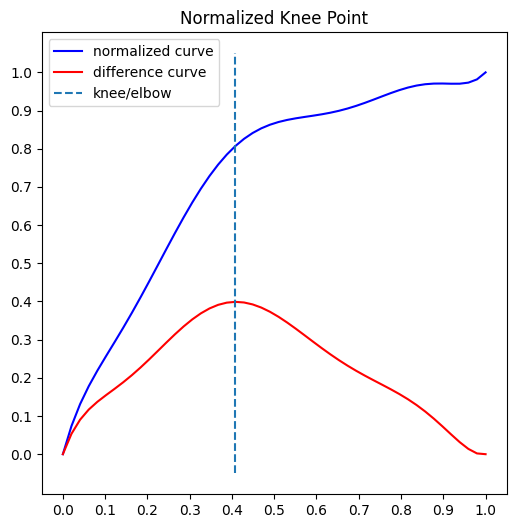

In [75]:
# use kneepoint method to get number of PCs to use
init_npcs = 50
sc.pp.pca(adata, n_comps=init_npcs)
x = [x for x in range(len(adata.uns['pca']['variance_ratio']))]
y = np.log(adata.uns['pca']['variance_ratio'])
knee = KneeLocator(x=x, y=y, curve='convex', direction='decreasing', online=True, interp_method='polynomial')
knee.plot_knee_normalized()

In [76]:
# recompute PCs with optimal PCs, then compute UMAP
opt_n_pcs = knee.knee+1
print('Optimal Number of PCs: ', str(opt_n_pcs))
sc.pp.pca(adata, n_comps=opt_n_pcs)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

Optimal Number of PCs:  21


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


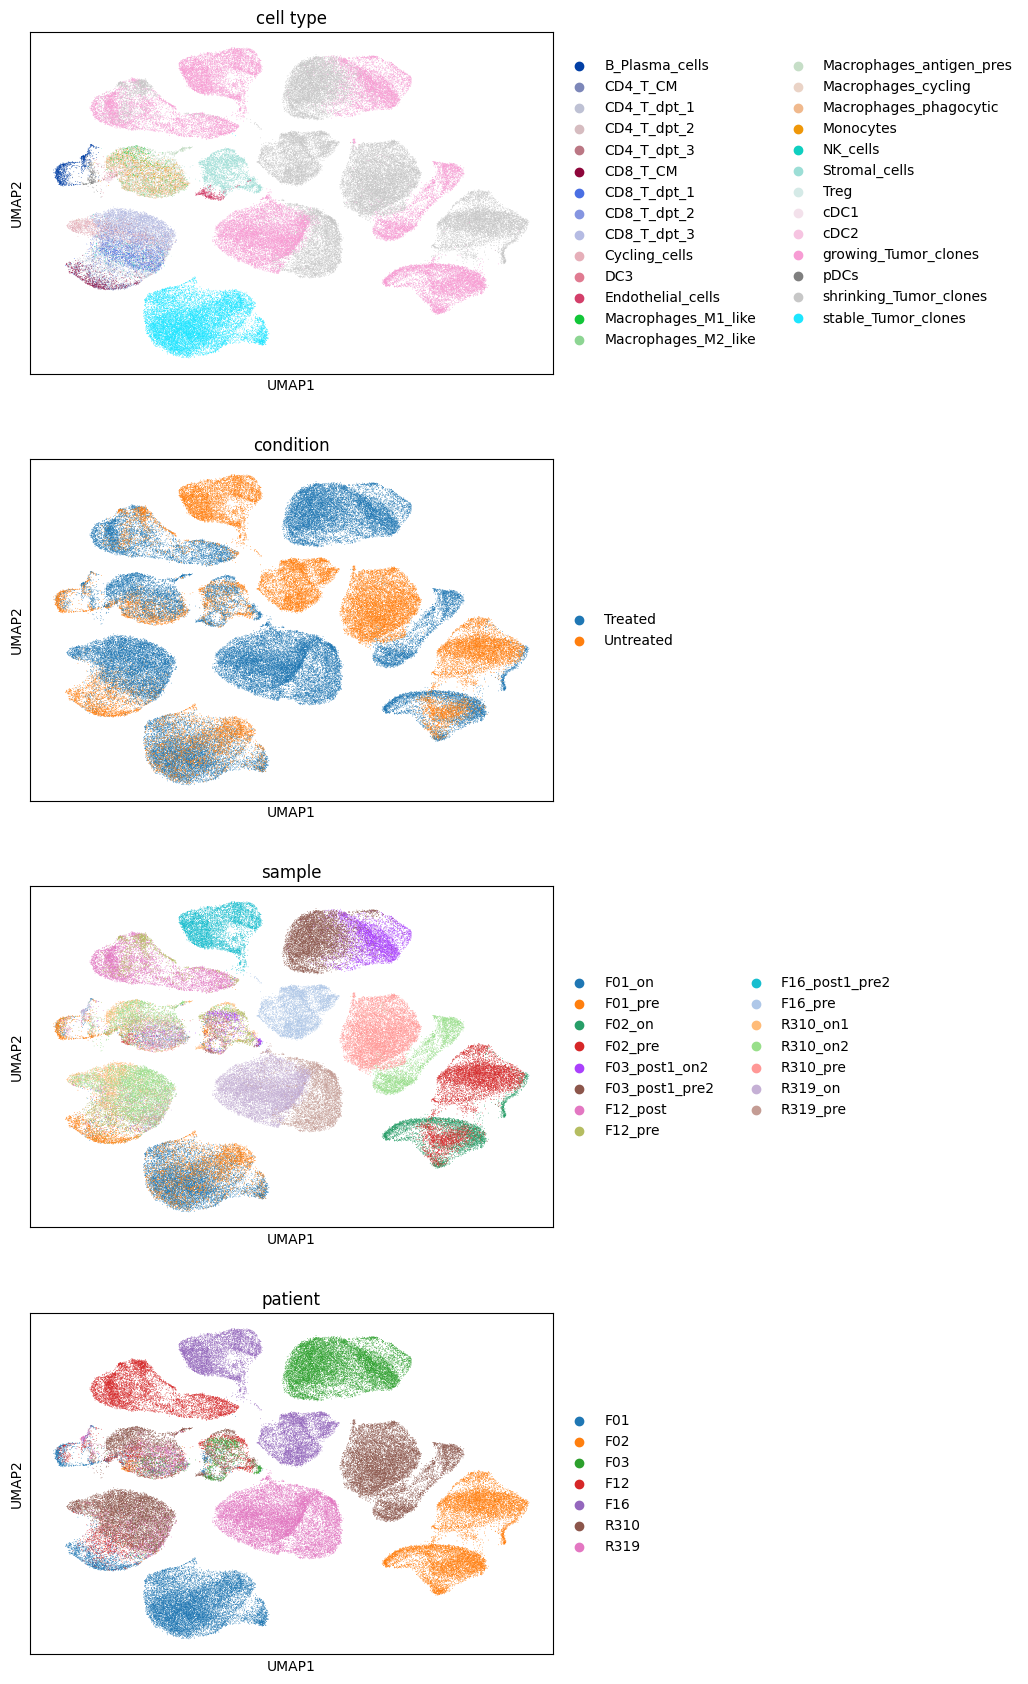

In [77]:
sc.pl.umap(adata, color=['cell type', 'condition', 'sample','patient'], ncols=1)

__The data above looks good, a single cluster per cell type: mixing between conditions/samples within each cluster__

If your data does not cluster like this, you are likely to get spurious results from ContactTracing. For example, if the two conditions are in two separate clusters for a single cell type, you will likely see a huge number of 'interaction effects' in the receptors for that cell type. 

In [78]:
adata.obs[['sample', 'condition']].value_counts()

sample          condition
R319_on         Treated      10720
R310_on2        Treated      10377
R310_pre        Untreated    10188
F01_on          Treated       9758
F02_pre         Untreated     8578
F03_post1_pre2  Treated       7935
F01_pre         Untreated     6410
F03_post1_on2   Treated       6350
F12_post        Treated       6170
F16_pre         Untreated     5949
F16_post1_pre2  Untreated     5678
R319_pre        Treated       5596
F02_on          Treated       5089
R310_on1        Treated       4025
F12_pre         Untreated     4018
dtype: int64

In [79]:
adata.raw = None
adata.write_h5ad('./data/contact_tracing_merged_082224_processed.h5ad', compression='gzip')

## Read interactions file -- start from here if crashing

In [8]:
rerun=True # set flag to true to avoid running unnecessary blocks

In [13]:
adata = sc.read_h5ad('./data/contact_tracing_merged_082224_processed.h5ad')

In [14]:
interactions = pd.read_csv(interactions_file, sep='\t')
interactions

,ligand,receptor
0,APP,FPR2
1,APP,SORL1
2,APP,TNFRSF21
3,APP,CD74
4,ADORA1,ENTPD1
...,...,...
975,TAC1,TACR3
976,TSHB,TSHR
977,ADCYAP1,VIPR1
978,SCT,VIPR1


__Should not have any duplicated interactions; if so, remove__

In [15]:
f = interactions[['ligand', 'receptor']].duplicated()
if sum(f) > 0:
    print(f'Removing {sum(f)} duplicated interactions')
    interactions = interactions.loc[~f]

__Remove any interactions that don't have both genes in adata__

In [16]:
allgenes = list(set(adata.var.index))
f = interactions['ligand'].isin(allgenes) & (interactions['receptor'].isin(allgenes))
print(f'Removing {sum(~f)} interactions that do not have both genes in adata')
interactions = interactions.loc[f]

Removing 7 interactions that do not have both genes in adata


## Find ligands that are differentially expressed in each cell type

In [17]:
output_dir

'./data/cell_type_ct_dpt'

In [73]:
# set this list to all interesting ligand cell types
ligand_cellTypes = list(adata.obs['cell type'].unique())
ligand_cellTypes

['stable_Tumor_clones',
 'B_Plasma_cells',
 'Stromal_cells',
 'DC3',
 'Macrophages_antigen_pres',
 'Endothelial_cells',
 'Cycling_cells',
 'Macrophages_phagocytic',
 'Macrophages_M1_like',
 'cDC2',
 'CD4_T_dpt_3',
 'cDC1',
 'Treg',
 'Macrophages_M2_like',
 'Macrophages_cycling',
 'pDCs',
 'Monocytes',
 'NK_cells',
 'CD4_T_dpt_1',
 'CD8_T_CM',
 'CD8_T_dpt_1',
 'CD4_T_CM',
 'CD4_T_dpt_2',
 'CD8_T_dpt_3',
 'CD8_T_dpt_2',
 'growing_Tumor_clones',
 'shrinking_Tumor_clones']

In [75]:
mast_outdir=f'{output_dir}/MAST_between_conditions'
!mkdir -p {mast_outdir}

__Run MAST on each cell type, comparing the two conditions__

Note: cngeneson is a recommended covariate in this analysis.

You can add other covariates to the analysis by adding them to the --covariates option, as a comma-delimited list. For example, to add sample name, for example, use the argument: --covariates cngeneson,sample. This requires adata.obs['sample'] ato be defined. Note, it will not make sense for sample to be a covariate unless individual samples are represented in both conditions.

In [77]:
ligands = list(interactions['ligand'].unique())

In [21]:
## Each command will take several minutes (or more, depending on data set size).
## Set this value to False if you prefer to copy commands to a script and run outside the notebook.
runCommands=True

In [22]:
len(ligand_cellTypes)

27

The command below runs MAST on each cell type.

Note the numCore option below, this is how many cores will be used by each command. 

Note also that each command will take some RAM (the amount depending on # of cells in each cell type, and # of genes). You may want to run 'top' on your server and see how much RAM is being used. It is possible that RAM will be the bottleneck, rather than # of cores available. In this case you will need to kill the jobs and restart with fewer cores, or run them one a time.

Alternatively, you can set runCommands=False. Then it will just print the commands that need to be run. You can copy/paste the commands into a terminal within the docker container. Or, you can write them to a file, and use gnu parallel to run them in parallel, with a command like 'parallel -j 5 < commands.txt' (this will run 5 commands simultaneously, it should also be done in a terminal within the docker container).

In [23]:
condition1 = 'Treated'
condition2 = 'Untreated'

In [24]:
# SKIP THIS IF RERUNNING
if not rerun:
    wait=True   # if wait=True, run each command one at a time. Otherwise, run them all at once (make sure to have sufficient cores/RAM).
                # if wait=False, this command will finish quickly, but MAST jobs will be running in the background, you will need to wait for them
                # to finish before proceeding. (The next block will tell you if any output files are not found).
    numCore=10  # number of cores to use for each MAST command

    runCommands=True  #if False, just print commands (do not run them). See comments above.
    for cellType in ligand_cellTypes:
        outdir=f'{mast_outdir}/{cellType}'
        !mkdir -p {outdir}
        mast_infile = f'{tmp_output_dir}/adata_{cellType}_ligands.h5ad'
        tmp = adata[adata.obs['cell type'] == cellType, ligands].copy()
        tmp.write(mast_infile)
        # note: add --force option here if you want to overwrite previous results and re-run
        cmd=f'{Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{mast_outdir}/{cellType}" --groups "condition"'
        cmd += f' --covariates cngeneson --numcore {numCore} --comp-groups {condition1} {condition2}'
        cmd += f' < {tutorial_dir}/R/MAST_wrapper.R'
        if runCommands:
            # Note: if force=False below, will not run if stdoutfile exists already 
            # if wait=False, will run commands in background and return to notebook,
            #    so commands for each cellType will run concurrently.
            #    In this case you may want to decrease --numcore in command above, or else server 
            #    could get overwhelmed if there are many cell types
            ct.run_in_background(cmd, stdoutfile=f'{outdir}/stdout.txt', quiet=True, wait=True, force=False)
        else:
            print(f'{cmd} &> {outdir}/stdout.txt')

In [78]:
# when MAST commands finished, load results and find DE ligands
# (This code also deletes the temporary adata files after reading results)
resultlist = []
for cellType in ligand_cellTypes:
    infile = f'{mast_outdir}/{cellType}/{condition1}_vs_{condition2}.csv'
    if not os.path.exists(infile):
        print(f'{cellType} not done yet')
        continue
    print(f'Removing {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    os.system(f'rm -f {tmp_output_dir}/adata_{cellType}_ligands.h5ad')
    tmp = ct.read_mast_results(infile)
    tmp['gene'] = tmp.index
    tmp['cell type'] = cellType
    tmp = tmp.loc[[x for x in tmp.index if x in ligands]]
    resultlist.append(tmp)
ligandsDE = pd.concat(resultlist, ignore_index=True)
ligandsDE

Removing ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_stable_Tumor_clones_ligands.h5ad
Reading ./data/cell_type_ct_dpt/MAST_between_conditions/stable_Tumor_clones/Treated_vs_Untreated.csv
Removing ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_B_Plasma_cells_ligands.h5ad
Reading ./data/cell_type_ct_dpt/MAST_between_conditions/B_Plasma_cells/Treated_vs_Untreated.csv
Removing ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Stromal_cells_ligands.h5ad
Reading ./data/cell_type_ct_dpt/MAST_between_conditions/Stromal_cells/Treated_vs_Untreated.csv
Removing ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_DC3_ligands.h5ad
Reading ./data/cell_type_ct_dpt/MAST_between_conditions/DC3/Treated_vs_Untreated.csv
Removing ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Macrophages_antigen_pres_ligands.h5ad
Reading ./data/cell_type_ct_dpt/MAST_between_conditions/Macrophages_antigen_pres/Treated_vs_Untreated.csv
Removing ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Endothelial_cells_ligands.h5ad
Reading ./data/cell_type_ct_dpt

,p,log2FC,ci.hi,ci.lo,fdr,bonferroni,rank_score,FC,scaled_rank_score,abs_scaled_rank_score,gene,cell type
0,3.227041e-107,0.419540,0.457061,0.382020,1.403763e-105,1.403763e-104,1038.527062,1.337501,435.703924,435.703924,SDC2,stable_Tumor_clones
1,3.872929e-110,0.384066,0.416348,0.351785,1.871916e-108,1.684724e-107,1067.734712,1.305015,410.080726,410.080726,NCAM1,stable_Tumor_clones
2,2.580182e-36,0.217440,0.249992,0.184889,5.907259e-35,1.122379e-33,329.498604,1.162669,71.646329,71.646329,CADM1,stable_Tumor_clones
3,2.174532e-37,0.140409,0.160388,0.120430,5.564243e-36,9.459214e-35,340.241450,1.102218,47.772950,47.772950,PDGFD,stable_Tumor_clones
4,3.649216e-27,0.174533,0.206586,0.142481,7.559091e-26,1.587409e-24,237.993111,1.128599,41.537690,41.537690,GJC1,stable_Tumor_clones
...,...,...,...,...,...,...,...,...,...,...,...,...
11740,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NMS,shrinking_Tumor_clones
11741,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,SST,shrinking_Tumor_clones
11742,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,TSHB,shrinking_Tumor_clones
11743,1.000000e+00,NaN,NaN,NaN,1.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,UCN3,shrinking_Tumor_clones


Text(0, 0.5, 'min adjusted p-value')

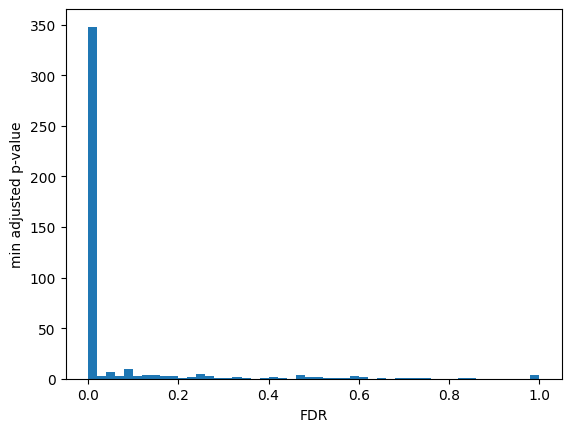

In [26]:
# compute minimum FDR for each ligand across all cell types
minLigandFDR = ligandsDE[['gene', 'fdr']].groupby('gene').min()
plt.hist(minLigandFDR['fdr'], bins=50)
plt.xlabel('FDR')
plt.ylabel('min adjusted p-value')

In [27]:
minLigandFDR.sort_values(by='fdr')

,fdr
gene,
CD58,3.972288e-321
DSG2,3.583422e-314
COL3A1,1.796304e-308
NRXN3,6.899757e-307
CEACAM1,1.884726e-303
...,...
PDYN,8.407287e-01
INS,1.000000e+00
CCL1,1.000000e+00


In [28]:
sigLigands = list(minLigandFDR.loc[minLigandFDR['fdr'] < 0.05].index)
print(f'{len(sigLigands)} out of {len(ligands)} are significantly DE')

352 out of 435 are significantly DE


In [29]:
keepInteractions = interactions['ligand'].isin(sigLigands)
print(f'Keeping {sum(keepInteractions)} out of {interactions.shape[0]} interactions')

Keeping 804 out of 973 interactions


In [30]:
interactions = interactions.loc[keepInteractions]

__The plots below show DE genes within each cell type. Positive log2FC means the genes are up in condition1__

In [31]:
# SKIP IF RERUNNING
if not rerun:
    for cellType in ligand_cellTypes:
        # note: this function can take awhile if max_num_label is big
        ct.make_volcano_plot(ligandsDE.loc[ligandsDE['cell type'] == cellType], title=cellType, ycol='fdr', label_col='gene',
                             fontsize=10, ylabel='FDR', max_num_label=10,
                             plot_outfile=f'{mast_outdir}/figures/{condition1}_vs_{condition2}_{cellType}.png')

## Run interaction test on receptors associated with DE ligands

This is computationally quite expensive, it can take many minutes per receptor, per cell type. Run-time and memory usage increases with the number of cells. If you use too many cores you may run out of memory and jobs will crash. Some ways to reduce runtime, which are implemented in this notebook, include:
- Only run on cell types / receptors of interest
- Only run on receptors with expression levels above some threshold
- Only run on receptors associated with DE ligands
- Assess interaction effect only in HVGs rather than across genes

In [32]:
# List of cell types that you want to assess interaction effect in
# not necessarily all cell types are of interest
# receptor_cellTypes = ['PMN_gMDSC', 'Macrophages_mMDSC', 'T_cells', 'Tumor_cells']
receptor_cellTypes = ligand_cellTypes

In [33]:
# receptors to run on; alternatively, set this to a list of interesting receptors
interaction_receptors = list(interactions['receptor'].unique())
print(f'Num receptors = {len(interaction_receptors)}')

Num receptors = 359


In [34]:
# use this if not reducing to hvgs
keepGenes=list(adata.var.index)

In [35]:
len(keepGenes)

18211

### Run interaction tests

This is the slowest part of the analysis, this section could take many days, depending on number of receptors/ cell types and size of data set, and the computational resource (# of CPUs and memory available).

The commands will be written to a script, and the script executed outside the notebook using GNU parallel

In [40]:
# split adata by cellType, compute fraction of cells expressing each gene per cell type, and write adata object to file
# do for all cell types (not just receptor) because will use later
all_fracExp = []
adata_cellTypes = {}
for cellType in adata.obs['cell type'].unique():
    adata_cellTypes[cellType] = adata[adata.obs['cell type'] == cellType, keepGenes].copy()
    adata_cellTypes[cellType].var['fracExp'] = np.sum(adata_cellTypes[cellType].layers['logX'] > 0, axis=0)/adata_cellTypes[cellType].shape[0]
    if cellType in receptor_cellTypes:
        all_fracExp += list(adata_cellTypes[cellType].var.loc[interaction_receptors, 'fracExp'])
        # uncomment if running for the first time
        # adata_cellTypes[cellType].write(f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad') 

__Choose cutoff for receptor expression__

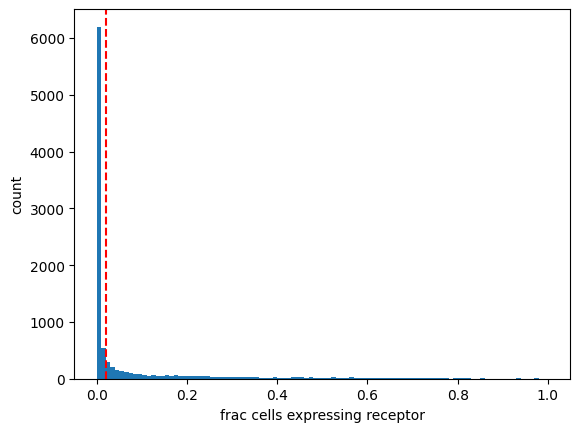

In [41]:
# look at distribution of fraction cells expressing receptors; may use this to choose cutoff for fracExp
fracExp_cutoff = 0.02
plt.hist(all_fracExp, bins=100)
plt.axvline(fracExp_cutoff, color='red', linestyle='--')
plt.xlabel('frac cells expressing receptor')
plt.ylabel('count')
plt.show()

In [42]:
for cellType in receptor_cellTypes:
    skipping = adata_cellTypes[cellType].var.loc[interaction_receptors,'fracExp'] < fracExp_cutoff
    print(f'{cellType}: Skipping {sum(skipping)} receptors with fracExp < {fracExp_cutoff:0.2f}, {sum(~skipping)} receptors remaining')

stable_Tumor_clones: Skipping 246 receptors with fracExp < 0.02, 113 receptors remaining
B_Plasma_cells: Skipping 278 receptors with fracExp < 0.02, 81 receptors remaining
Stromal_cells: Skipping 186 receptors with fracExp < 0.02, 173 receptors remaining
DC3: Skipping 228 receptors with fracExp < 0.02, 131 receptors remaining
Macrophages_antigen_pres: Skipping 236 receptors with fracExp < 0.02, 123 receptors remaining
Endothelial_cells: Skipping 220 receptors with fracExp < 0.02, 139 receptors remaining
Cycling_cells: Skipping 265 receptors with fracExp < 0.02, 94 receptors remaining
Macrophages_phagocytic: Skipping 245 receptors with fracExp < 0.02, 114 receptors remaining
Macrophages_M1_like: Skipping 247 receptors with fracExp < 0.02, 112 receptors remaining
cDC2: Skipping 242 receptors with fracExp < 0.02, 117 receptors remaining
CD4_T_dpt_3: Skipping 277 receptors with fracExp < 0.02, 82 receptors remaining
cDC1: Skipping 223 receptors with fracExp < 0.02, 136 receptors remaining


In [43]:
interaction_outdir=f'{output_dir}/interaction_test'
!mkdir -p {interaction_outdir}

__Write commands to run.__

As in the MAST analysis of ligands, covariates can be added to the command below, by adding any column of anndata's .obs matrix to the `--covariates` option below. They should be comma-delimited, i.e., to add scrublet score, change to `--covariates cngeneson,scrublet`

We had a reviewer suggest doublet score as a covariate, adding this did not hurt but also didn't change results. It does not seem to increase run-time to add covariates, so any covariate that may influence gene expression levels may be sensible to add, any column in adata.obs can be included (though it should have a name without spaces or strange characters).  Note that if each sample is from a single condition, then sample is not an appropriate covariate, since the it will be impossible to disentangle the condition effect from the sample effect.

#### Generate command file

In [44]:
# This nay take several minutes to run, depending on number of cell types/receptors.
# It checks expression of each receptor in each condition to make sure there is sufficient data.

# set force to True to run all tests, otherwise only run genes if output file does not already exist
force=False
command_file = open(f'{interaction_outdir}/commands.sh', 'w')
expected_files = set()
num_commands=0
for cellType in receptor_cellTypes:
    curr_adata = adata_cellTypes[cellType]
    keep_receptors = curr_adata.var.loc[interaction_receptors,'fracExp'] >= fracExp_cutoff
    genes = list(keep_receptors.loc[keep_receptors].index)

    outdir=f'{interaction_outdir}/{cellType}'
    !mkdir -p {outdir}
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    
    curr_logX = curr_adata.layers['logX']
    fcond1 = np.array(curr_adata.obs['condition'] == condition1)
    fcond2 = np.array(curr_adata.obs['condition'] == condition2)
    for gene in genes:
        output_file = f'{interaction_outdir}/{cellType}/{gene}/interaction_{condition1}_vs_{condition2}.txt'
        
        # check to see if we have data to analyze this gene.
        # we require at least two cells expressing the receptor and two not expressing
        # Additionally, there should be at least one cell expressing and non-expressing for each condition
        geneidx = np.where(curr_adata.var.index == gene)[0]
        fexp = np.array(curr_logX[:,geneidx] > 0).flatten()
        if sum(fexp) < 2:
            continue
        if sum(~fexp) < 2:
            continue
        if (sum(fexp & fcond1) == 0):
            continue
        if (sum(fexp & fcond2)==0):
            continue
        if (sum((~fexp) & fcond1) == 0):
            continue
        if (sum((~fexp) & fcond2) == 0):
            continue
        expected_files.add(output_file)
        if force==False and os.path.exists(output_file):
            continue
        
        cmd=f'mkdir -p {outdir}/{gene} && {Rcommand} --vanilla --args --infile "{mast_infile}" --outdir "{interaction_outdir}/{cellType}"'
        cmd += f' --conditions "{condition1}" "{condition2}"'
        cmd += f' --covariates cngeneson --numcore 1 --genes "{gene}"'
        if force:
            cmd += f' --force'
        cmd += f' < {tutorial_dir}/R/MAST-interactionTest.R &> {outdir}/{gene}/stdout.txt\n'
        command_file.write(cmd)
        num_commands = num_commands+1
command_file.close()
print(f'Wrote command file {interaction_outdir}/commands.sh with {num_commands} commands')

Wrote command file ./data/cell_type_ct_dpt/interaction_test/commands.sh with 281 commands


In [45]:
# This is total number of interaction tests we need to run
len(expected_files)

2865

__Set the jobs running, using parallel command__

In this cell below, `-j 10` specifies the number of simultaneous jobs to run. Each job uses a single core (as indicated by the --numcore 1 option used above; the MAST run can be parallelized, but most efficient is to run each job on a single core, and run many jobs simultaneously).

I recommend first executing the following cell with '-j 1' (one job only) and then using 'top' in a terminal to determine how much memory the job uses. Then, depending on how many cores and how much memory is available on your machine, you can kill the job (using code below, under the comment HERE IS CODE TO KILL ALL JOBS). Then restart with a number of jobs that your machine can handle.

For example, if one job takes 10 Gb of memory, and your machine has 256 Gb memory available, you should be able to use -j 25, or maybe -j 24 to leave some wiggle room. However, if your machine only has 10 cores, then you will need to use -j 10.

Note that the amount of memory required is proportional to both the number of cells in the data set, and the number of genes being analyzed. So if there are multiple cell types in receptor_cellTypes (each with a different number of cells), you should test the memory usage on a job from the biggest cell type. Or, you can split the jobs up by cell type, and use different levels of parallelization depending on the memory requirements for each.

In [47]:
# generally: -j 15 for tumor clones; 20+ for other cell types
ct.run_in_background(f'parallel -j 15 < {interaction_outdir}/commands.sh', 
                     stdoutfile=f'{interaction_outdir}/commands_stdout.txt')

calling bash -c 'parallel -j 15 < ./data/cell_type_ct_dpt/interaction_test/commands.sh' > ./data/cell_type_ct_dpt/interaction_test/commands_stdout.txt 2>&1 &



Once jobs have started, you can use the command below to check how many have finished.

In [50]:
# check progress of jobs
numdone=0
for f in expected_files:
    if os.path.exists(f):
        numdone=numdone+1
print(f'Done {numdone} out of {len(expected_files)} interaction tests')

Done 2865 out of 2865 interaction tests


It is recommend to run 'top' on the server to see how memory and CPU usage is doing.

If you are overrunning resources, some jobs may crash and need to be restarted, or you may need to kill all processes (using the code block below). If your jobs don't all finish on the first pass, you can go back up to the 'Generate command file' cell above, make sure to set `force=False`, and it will generate a new commands file containing only the jobs that haven't completed yet. You can then repeat this process until all jobs have finished.

In [121]:
# HERE IS CODE TO KILL ALL JOBS, in case you are overrunning memory or something
# (Note this will kill any R job or parallel command running, but only within the docker container)
subprocess.run(["killall", "parallel"])
subprocess.run(["killall", "/usr/local/lib/R/bin/exec/R"])

/usr/local/lib/R/bin/exec/R: no process found


CompletedProcess(args=['killall', '/usr/local/lib/R/bin/exec/R'], returncode=1)

__When all jobs finished, you may clean up temporary adata files__

In [52]:
for cellType in receptor_cellTypes:
    mast_infile = f'{tmp_output_dir}/adata_{cellType}_inttest.h5ad'
    print(f'Deleting {mast_infile}')
    os.system('rm -f {mast_infile}')

Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_stable_Tumor_clones_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_B_Plasma_cells_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Stromal_cells_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_DC3_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Macrophages_antigen_pres_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Endothelial_cells_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Cycling_cells_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Macrophages_phagocytic_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_Macrophages_M1_like_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_cDC2_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_CD4_T_dpt_3_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP/adata_cDC1_inttest.h5ad
Deleting ./data/cell_type_ct_dpt/tmp/NOBACKUP

## Read in interaction test results

Need to wait for all interaction tests to finish before coming to this section

In [53]:
inttest = f'interaction_{condition1}_vs_{condition2}'

In [54]:
# the function is I/O intensive so you may not want to use too many cores
ncore=20
deg = ct.read_all_contactTracing_results(receptor_cellTypes, interaction_receptors, interaction_outdir, 
                                         cond1=condition1, cond2=condition2,
                                         inttest=inttest, ncore=ncore, genes=keepGenes)
deg

Done reading files, 2865 found of 9693 combinations. concatenating.
Done


AnnData object with n_obs × n_vars = 2865 × 18211
    obs: 'cell type', 'receptor'
    layers: 'coef_Treated_cluster', 'coef_Untreated', 'coef_cluster', 'pval', 'fdr.i1'

The 'deg' object is an AnnData structure, where each row is a cell_type/receptor combination, 
there is a column for each gene tested for transcriptional response. The layers returned are:
- coef_{condition1}\_cluster: the logFC applied to cells in the condition1/receptor_on category. This is the 'interaction_coefficient'. In this case the column name is coef_highCIN_cluster.
- coef_{condition2}: the logFC applied to cells in the lowCIN categories (receptor on or off). In this case the column name is coef_lowCIN
- coef_cluster: the logFC applied to cells in the receptor_on category (both conditions)
- pval: The p-value describing the significance of the interaction coefficient
- fdr.i1: FDR-corrected p-value. FDR correction is done independently across each row.

In [55]:
deg

AnnData object with n_obs × n_vars = 2865 × 18211
    obs: 'cell type', 'receptor'
    layers: 'coef_Treated_cluster', 'coef_Untreated', 'coef_cluster', 'pval', 'fdr.i1'

In [56]:
# compute number of significant interactions for each row
deg.obs['numSigI1_fdr05'] = np.sum(deg.layers['fdr.i1'] < 0.05, axis=1)

In [57]:
deg.obs

,cell type,receptor,numSigI1_fdr05
0,stable_Tumor_clones,TNFRSF21,220
1,stable_Tumor_clones,CD74,17
2,stable_Tumor_clones,NCAM1,984
3,stable_Tumor_clones,PTPRS,269
4,stable_Tumor_clones,SORT1,234
...,...,...,...
2860,shrinking_Tumor_clones,NLGN4X,10001
2861,shrinking_Tumor_clones,NLGN4Y,3415
2862,shrinking_Tumor_clones,NPFFR2,1668
2863,shrinking_Tumor_clones,SLITRK2,13204


## Generate a ranked list of interactions

This is one possibly way to rank interactions - of all the interactions with a differentially expressed ligand, rank by size of interaction effect (numSigI1_fdr05)

In [58]:
ligands = ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'ligand',
                                                                           'cell type':'cell_type_ligand'})

In [59]:
# some ligands have log2FC=NA but they are not significant (check)
ligands.loc[pd.isna(ligands['log2FC']),'fdr'].unique()

array([1.])

In [60]:
# they all have FDR of 1 so just set log2FC to 0
ligands.loc[pd.isna(ligands['log2FC']),'log2FC'] = 0

In [61]:
ligands['ligandDE'] = ligands['fdr'] < 0.05

In [62]:
receptors = deg.obs.rename(columns={'cell type':'cell_type_receptor'})

In [63]:
ranked_interactions = interactions.merge(ligands, on='ligand').merge(receptors, on='receptor').sort_values(
    by=['ligandDE', 'numSigI1_fdr05'], ascending=False)[['ligand', 'cell_type_ligand', 'receptor', 'cell_type_receptor',
                                                         'log2FC', 'fdr', 'ligandDE', 'numSigI1_fdr05']].rename(
    columns={'log2FC':'log2FC_ligand', 'fdr':'fdr_ligand', 'numSigI1_fdr05':'numSigI1_fdr05_receptor'})
ranked_interactions.to_csv(f'{output_dir}/ranked_interactions.txt', index=False, sep='\t')
print(f'Wrote ranked interaction list to {output_dir}/ranked_interactions.txt')

Wrote ranked interaction list to ./data/cell_type_ct_dpt/ranked_interactions.txt


<Axes: xlabel='numSigI1_fdr05_receptor', ylabel='Count'>

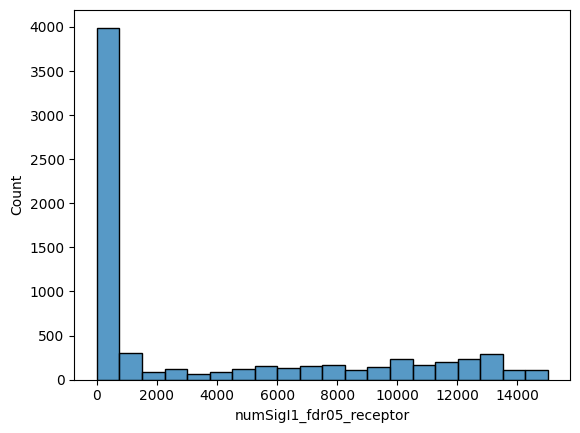

In [64]:
# Here are top 5
import seaborn as sns
sns.histplot(ranked_interactions[(ranked_interactions['ligandDE']) & (ranked_interactions['numSigI1_fdr05_receptor'] > 1)], x='numSigI1_fdr05_receptor')

<Axes: xlabel='numSigI1_fdr05_receptor', ylabel='Count'>

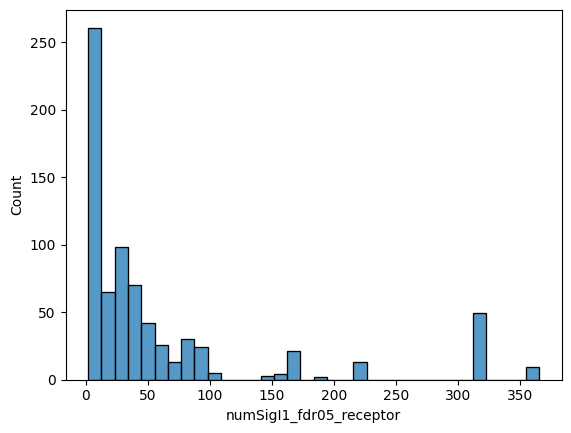

In [65]:
cells_of_interest = ['Macrophages_antigen-pres.', 
                     'Macrophages_phagocytic', 'Macrophages_M1-like', 'CD8+_T_cells', 'CD4+_T_cells', 'cDC1', 'Tregs', 
                     'Macrophages_M2-like', 'Macrophages_cycling', 'cDC2', 'Monocytes', 'NK_cells', 'pDCs', 'Naive_CD8+_T_cells']
sns.histplot(ranked_interactions[(ranked_interactions['cell_type_receptor'].isin(cells_of_interest)) & (ranked_interactions['ligandDE']) & (ranked_interactions['numSigI1_fdr05_receptor'] > 1)], x='numSigI1_fdr05_receptor')

In [66]:
ranked_interactions[(ranked_interactions['cell_type_receptor'].isin(cells_of_interest)) & (ranked_interactions['ligandDE']) & (ranked_interactions['numSigI1_fdr05_receptor'] > 1)]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
97313,PECAM1,stable_Tumor_clones,CD38,Macrophages_phagocytic,-0.002777,1.947580e-04,True,365
97337,PECAM1,B_Plasma_cells,CD38,Macrophages_phagocytic,0.487728,1.990931e-09,True,365
97361,PECAM1,Stromal_cells,CD38,Macrophages_phagocytic,-0.000960,3.241431e-03,True,365
97505,PECAM1,Macrophages_M1_like,CD38,Macrophages_phagocytic,-0.364115,4.439272e-04,True,365
97601,PECAM1,Treg,CD38,Macrophages_phagocytic,-0.276164,1.570379e-05,True,365
...,...,...,...,...,...,...,...,...
117601,SIRPG,shrinking_Tumor_clones,CD47,Monocytes,0.001065,2.053385e-02,True,2
140817,CD320,stable_Tumor_clones,JAML,Monocytes,-0.037526,4.551541e-03,True,2
140859,CD320,Stromal_cells,JAML,Monocytes,-0.034815,4.927818e-04,True,2
141342,CD320,growing_Tumor_clones,JAML,Monocytes,0.068603,1.227214e-26,True,2


In [67]:
deg.shape

(2865, 18211)

You can also make a list of ranked interactions integrated over ligand cell type, for example, require ligand DE in one cell type

Here, the values of ligand cell type, log2FC, and fdr are all for the ligand cell type with minimum fdr value

In [68]:
ranked_interactions2 = ranked_interactions.loc[ranked_interactions.drop(columns='cell_type_ligand').groupby(
    ['ligand', 'receptor', 'cell_type_receptor']).idxmin()['fdr_ligand']].sort_values(
    by=['ligandDE', 'numSigI1_fdr05_receptor'], ascending=False)
ranked_interactions2.to_csv(f'{output_dir}/ranked_interactions_across_ligand_cell_type.txt', index=False, sep='\t')
print('Wrote ranked interaction list (integrated over ligand cell type) to {output_dir}/ranked_interactions_across_ligand_cell_type.txt')

Wrote ranked interaction list (integrated over ligand cell type) to {output_dir}/ranked_interactions_across_ligand_cell_type.txt


In [69]:
ranked_interactions2.iloc[:5]

,ligand,cell_type_ligand,receptor,cell_type_receptor,log2FC_ligand,fdr_ligand,ligandDE,numSigI1_fdr05_receptor
99790,PGF,shrinking_Tumor_clones,NRP2,growing_Tumor_clones,0.017552,5.536015e-27,True,15014
100222,SEMA3C,shrinking_Tumor_clones,NRP2,growing_Tumor_clones,0.745080,1.000000e-240,True,15014
100654,SEMA3F,shrinking_Tumor_clones,NRP2,growing_Tumor_clones,-0.002140,6.983098e-09,True,15014
101070,VEGFA,growing_Tumor_clones,NRP2,growing_Tumor_clones,-0.417132,1.000000e-240,True,15014
116125,SEMA7A,growing_Tumor_clones,PLXNC1,growing_Tumor_clones,-0.026257,2.595119e-66,True,14785


In [70]:
deg.write_h5ad(output_dir+"/deg.h5ad")

## Explore downstream interaction effects

We can use the coef estimates in the deg structure, along with p-values, to explore downstream effects.

### Optional: fix NA coefficients

A substantial number of logFC estimates coming from MAST are recorded as NA, even when the p-value is significant. I believe this is because the MAST estimate is hitting +/- infinity, or passing some internal boundaries set by MAST. In this section we can replace the NAs with a rough estimate based on mean # of expressed cells in different categories.

Note: this section can be time-consuming, and is not necessary unless you want to explore the transcriptional response to a particular ligand-receptor interaction

In [55]:
condition1 = 'Treated'
condition2 = 'Untreated'

In [52]:
adata = sc.read_h5ad('./data/contact_tracing_merged_082224_processed.h5ad')
interactions = pd.read_csv('./data/ContactTracing_interactions.txt', sep="\t")
deg = sc.read_h5ad(output_dir+'/deg.h5ad')
target_stats = pd.read_csv(output_dir+'/target_stats.txt', sep="\t", index_col=0)
diffComp = sc.read_h5ad(output_dir+'/diffComp.h5ad')

__First, how many of these NAs are there?__

In [53]:
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
coef_layers = [x for x in deg.layers.keys() if x.startswith('coef') and not x.endswith('_est')] 
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

Out of 7945364 tests with fdr < 1:
  553001 (6.96%) have coef_Treated_cluster=NA
  60785 (0.77%) have coef_Untreated=NA
  80027 (1.01%) have coef_cluster=NA


In [64]:
# only fix the ones for T cells for now
deg = deg[deg.obs['cell type'].isin(['CD4_T_CM', 'CD4_T_dpt_1', 
                                     'CD4_T_dpt_2', 'CD4_T_dpt_3', 
                                     'CD8_T_CM', 'CD8_T_dpt_1', 
                                     'CD8_T_dpt_2', 'CD8_T_dpt_3',])]

In [99]:
deg

AnnData object with n_obs × n_vars = 625 × 18211
    obs: 'cell type', 'receptor', 'numSigI1_fdr05'
    layers: 'coef_Treated_cluster', 'coef_Untreated', 'coef_cluster', 'fdr.i1', 'pval', 'coef_cluster_est', 'coef_Untreated_est', 'coef_Treated_cluster_est'

In [65]:
# Here is code that creates the estimates - for each coefficient in deg.layers, it addes another layer with the suffix _est that gives
# the rough estimated values

# Note- it will distribute each row of deg across the cores specified by ncores, in chunks of size chunksize.
# I have found it is much faster to use big chunks.
ct.estimate_contactTracing_coefs(deg, adata, condition1, condition2, ncores=10, chunksize=50)

Done 64 out of 625 (10.2%)
Done 127 out of 625 (20.3%)
Done 190 out of 625 (30.4%)
Done 253 out of 625 (40.5%)
Done 316 out of 625 (50.6%)
Done 379 out of 625 (60.6%)
Done 442 out of 625 (70.7%)
Done 505 out of 625 (80.8%)
Done 568 out of 625 (90.9%)


In [66]:
deg

AnnData object with n_obs × n_vars = 625 × 18211
    obs: 'cell type', 'receptor', 'numSigI1_fdr05'
    layers: 'coef_Treated_cluster', 'coef_Untreated', 'coef_cluster', 'fdr.i1', 'pval', 'coef_cluster_est', 'coef_Untreated_est', 'coef_Treated_cluster_est'

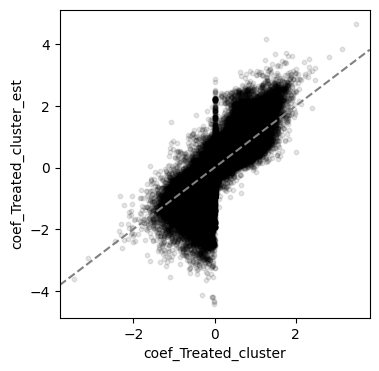

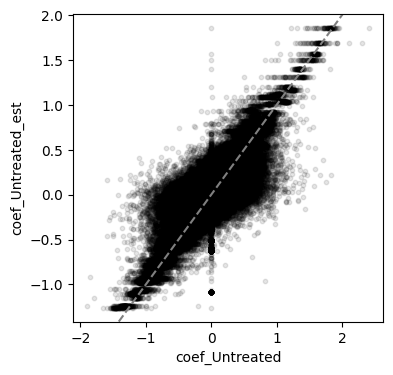

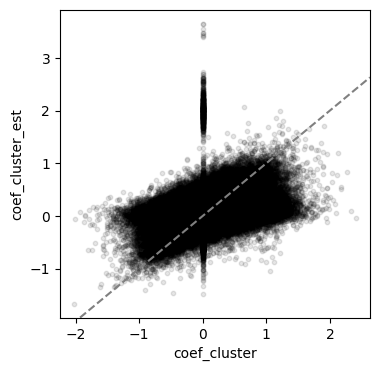

In [67]:
# plot MAST estimates vs rough estimates - they should fall along the diagonal, with a good deal of noise.
# (MAST model is much more sophisticated).
#log_factor = np.log10(2)
for layer in coef_layers:
    if f'{layer}_est' in deg.layers:
        plt.subplots(figsize=(4,4))
        plt.scatter(np.array(deg.layers[layer]).reshape(-1), 
                    np.array(deg.layers[f'{layer}_est']).reshape(-1), color='black', s=10, alpha=0.1)
        plt.gca().axline((1,1), slope=1, ls='--', color='gray')
        plt.xlabel(layer)
        plt.ylabel(f'{layer}_est')
        plt.show()

__If you want to replace NAs with estimated values, do:__

In [68]:
for layer in coef_layers:
    f = np.isnan(deg.layers[layer])
    deg.layers[layer][f] = deg.layers[f'{layer}_est'][f]

In [69]:
# confirm there are no more NAs
sig = deg.layers['fdr.i1'] < 1
print(f'Out of {sum(sum(sig))} tests with fdr < 1:')
for layer in coef_layers:
    na = np.isnan(deg.layers[layer])
    print(f'  {sum(sum(na & sig))} ({sum(sum(na & sig))/sum(sum(sig))*100:0.2f}%) have {layer}=NA')

Out of 13349 tests with fdr < 1:
  0 (0.00%) have coef_Treated_cluster=NA
  0 (0.00%) have coef_Untreated=NA
  0 (0.00%) have coef_cluster=NA


### Example plot showing interaction effect for single receptor in one cell type


The plot shows the log-fold coefficient for genes when the receptors is on, in each of the two conditions.

The color of the dot shows the size of the 'interaction effect'. The size of the dot shows the significance (-log10 pvalue).

Points falling along the diagonal show the same effect in both conditions, as you move away from the diagonal you can see genes that are affected differently.

Text(0.5, 1.0, 'CD8_T_dpt_1 PDCD1')

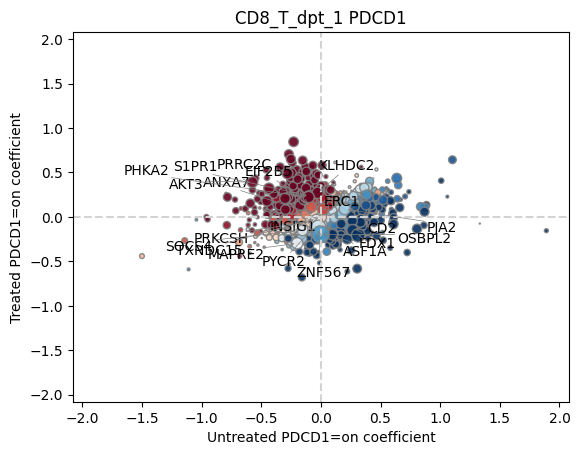

In [70]:
# change next two lines to cellType / gene of interest
cellType = 'CD8_T_dpt_1'
gene = 'PDCD1'
numLabel=20

idx = np.where((deg.obs['cell type'] == cellType) & (deg.obs['receptor'] == gene))[0][0]

pvals = deg.layers['pval'][idx,:].reshape(-1)
cond1On = (deg.layers[f'coef_{condition1}_cluster'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)
cond2On = (deg.layers[f'coef_{condition2}'][idx,:] + deg.layers['coef_cluster'][idx,:]).reshape(-1)

# color by interaction effect
cvals = deg.layers[f'coef_{condition1}_cluster'][idx,:].reshape(-1)

# size by p-value
svals = -np.log10(pvals)
# 150 just gives reasonable size dot, can adjust as needed
svals = svals * 150/np.max(svals)


nanvals = (np.isnan(cond1On)) | (np.isnan(cond2On))
f = (pvals < 1) & (~nanvals)
if sum(nanvals) > 0:
    print(f'Skipping {sum(nanvals)} points with NAN coefs and p-val < 1, plotting {sum(f)} genes')

order = np.argsort(svals[f])

tmpdf = pd.DataFrame({'xvals':cond2On[f][order],
                      'yvals':cond1On[f][order],
                      'gene':deg.var.index[f][order],
                      'color':cvals[f][order],
                      's':svals[f][order]})


plt.scatter(tmpdf['xvals'], tmpdf['yvals'], 
            c=tmpdf['color'], s=tmpdf['s'],
            edgecolors=ct.makeTransparent('gray', alpha=0.5),
            cmap=plt.cm.RdBu_r, vmin=-0.3, vmax=0.3, alpha=0.9)

tmpdf = tmpdf.sort_values(by='s', ascending=False).reset_index(drop=True)

# add text labels to most significant genes
use_numLabel = numLabel
if use_numLabel > sum(f):
    use_numLabel = sum(f)

texts = []
for i in tmpdf.iloc[:use_numLabel].index:
    texts.append(plt.text(tmpdf.loc[i,'xvals'], tmpdf.loc[i,'yvals'], tmpdf.loc[i,'gene'], fontsize=10))
niter = adjust_text(texts, 
                    x=list(tmpdf['xvals']), 
                    y=list(tmpdf['yvals']), 
                    #avoid_self=True, force_text=(2,2),
                    #force_pull=(0.001,0.001),
                    expand_points=(1.1, 1.1),
                    expand_text=(1.1,1.1),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
plt.xlabel(f'{condition2} {gene}=on coefficient')
plt.ylabel(f'{condition1} {gene}=on coefficient')
maxval = np.max(np.abs(list(cond2On[f])+list(cond1On[f])))*1.1
plt.xlim(-maxval, maxval)
plt.ylim(-maxval, maxval)
linelist=[]
linelist += plt.plot([-maxval, maxval], [0,0], c='lightgray', linestyle='dashed')
linelist += plt.plot([0,0], [-maxval, maxval], c='lightgray', linestyle='dashed')
plt.title(cellType + ' ' + gene)


## Run cluster test on all ligands/receptors and compute differential components

This is done in preparation of making the circos plot, we use diffusion components to create an ordering of ligands/receptors around the circle

In the CIN/TME paper, this was the 'cluster' test, run in MAST. We are testing for genes that are differentially expressed when the target gene is on vs off, for every target. But it is very slow to do in MAST and only used for visualization so it makes more sense to use a faster algorithm. Using scanpy here. It still takes awhile, but hopefully minutes to an hour or so, rather than days.

In [71]:
adata

AnnData object with n_obs × n_vars = 106841 × 18211
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rps', 'percent.rpl', 'percent.rp', 'sample', 'condition', 'barcode_orig', 'barcode_pat', 'predicted_doublets', 'doublet_scores', 'RNA_snn_res.0.8', 'seurat_clusters', 'clonotype_id', 'chain', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'frequency', 'proportion', 'cdr3s_aa', 'cdr3s_nt', 'inkt_evidence', 'mait_evidence', 'tcr', 'mait', 'inkt', 'both_chains', 'clone_size', 'mait_inkt', 'celltype_bped_main', 'celltype_bped_fine', 'celltype_hpca_main', 'celltype_hpca_fine', 'immune', 'has_cnv_chr1', 'has_loss_chr1', 'has_dupli_chr1', 'proportion_cnv_chr1', 'proportion_loss_chr1', 'proportion_dupli_chr1', 'proportion_scaled_cnv_chr1', 'proportion_scaled_loss_chr1', 'proportion_scaled_dupli_chr1', 'has_cnv_chr2', 'has_loss_chr2', 'has_dupli_chr2', 'proportion_cnv_chr2', 'proportion_loss_chr2', 'proportion_dupli_chr2', 'proportion_scaled_cnv_chr2', 'proportion_scaled_loss

In [72]:
cellTypes = adata.obs['cell type'].unique()
cellTypes

['stable_Tumor_clones', 'B_Plasma_cells', 'Stromal_cells', 'DC3', 'Macrophages_antigen_pres', ..., 'CD4_T_dpt_2', 'CD8_T_dpt_3', 'CD8_T_dpt_2', 'growing_Tumor_clones', 'shrinking_Tumor_clones']
Length: 27
Categories (27, object): ['B_Plasma_cells', 'CD4_T_CM', 'CD4_T_dpt_1', 'CD4_T_dpt_2', ..., 'growing_Tumor_clones', 'pDCs', 'shrinking_Tumor_clones', 'stable_Tumor_clones']

In [73]:
sig_receptors = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
sig_receptors.shape

(925, 3)

In [74]:
# Create object to hold differential expression results
# It is an anndata structure with rows for every target gene and cell type we are interested in
# and columns for every gene

# The targets we are interested in are receptors with some minimum number of interaction effects,
# and ligands associated with these receptors.

minInteractions=1

receptor_df = deg.obs.loc[deg.obs['numSigI1_fdr05'] >= minInteractions][['cell type', 'receptor']].rename(columns={'receptor':'target'})
ligand_df = pd.DataFrame(product(ligand_cellTypes, 
                                 interactions.loc[interactions['receptor'].isin(receptor_df['target']), 'ligand']),
                         columns=['cell type', 'target'])
targets_df = pd.concat([receptor_df, ligand_df])
targets_df = targets_df[~targets_df.duplicated()].sort_values(by=['cell type', 'target']).reset_index(drop=True)
targets_df.index = targets_df.index.map(str)
diffComp = sc.AnnData(X=np.empty(shape=(targets_df.shape[0], deg.var.shape[0]), dtype=np.float32),
                      obs=targets_df, var=deg.var)
diffComp

AnnData object with n_obs × n_vars = 8798 × 18211
    obs: 'cell type', 'target'

In [75]:
# add layers for all the DE statistics
diffComp.layers['pval'] = diffComp.X.copy()
diffComp.layers['fdr'] = diffComp.X.copy()
diffComp.layers['lfc'] = diffComp.X.copy()
diffComp.layers['score'] = diffComp.X.copy()

In [76]:
def de_score(targetCellType):
    (target, cellType) = targetCellType
    adata = adata_cellTypes[cellType]
    idx = np.where(adata.var.index == target)[0]
    isExpressed = np.reshape(adata.layers['logX'][:,idx] > 0, -1)
    tmpcol = f'{target}_cluster'
    adata.obs[tmpcol] = pd.Categorical(['expressed' if x else 'not' for x in isExpressed], categories=['expressed', 'not'])
    if (sum(adata.obs[tmpcol].value_counts() <=1) > 0):
        # cannot compute if we don't have more than one cell in both categories...skip
        adata.obs.drop(columns=tmpcol, inplace=True)
        return (target, cellType, 0)
    newkey=f'rank_genes_groups_{target}'
    sc.tl.rank_genes_groups(adata, groupby=tmpcol, layer='logX', method='wilcoxon', groups=['expressed'], key_added=newkey)
    adata.obs.drop(columns=tmpcol, inplace=True)
    tmprg = adata.uns[newkey]
    pvals = np.array([x[0] for x in tmprg['pvals']])
    minPval = np.min(pvals[pvals > 0])
    pvals[pvals==0] = minPval
    scores = np.array([x[0] for x in tmprg['scores']])
    fdr = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')[1]
    tmpdf = pd.DataFrame({'gene':[x[0] for x in tmprg['names']],
                          'pval':pvals,
                          'fdr':fdr,
                          'lfc':[x[0] for x in tmprg['logfoldchanges']],
                         'score':scores}).set_index('gene')
    tmpdf['score'] =  -np.log10(tmpdf['pval'])*tmpdf['lfc']
    adata.uns.pop(newkey)
    return (target,cellType,tmpdf)
    #return -np.log10(tmpdf['pval'])*tmpdf['lfc']

The following cell loops through all cell types, all ligands/receptors, and performs a test for differential expression across
all genes, for whehter gene expression is related to whether the ligand/receptor is expressed. It is all done
within the given cell type. In the end, `diffComp` is an adata object where:
- each row is a ligand or a receptor in a particular cell type
- each column is a gene (same columns as adata)
- there are matrices .layers['lfc'], .layers['pval'], .layers['fdr'], and .layers['score'] with results from rank_genes_groups function ('wilcoxan' method).

In [77]:
diffComp

AnnData object with n_obs × n_vars = 8798 × 18211
    obs: 'cell type', 'target'
    layers: 'pval', 'fdr', 'lfc', 'score'

In [78]:
# set this to the number of jobs you want to run simultaneously
num_processes=20
targetlist = [(diffComp.obs.loc[x, 'target'], diffComp.obs.loc[x, 'cell type']) for x in diffComp.obs.index]
numjob=diffComp.shape[0]
numdone=0
fracReport=0.01
nextfrac=0.01
print(f'Running LRT tests for all ligands/receptors')
with multiprocessing.Pool(processes=num_processes) as p:
    func = partial(de_score)
    for tmp in p.imap_unordered(func, targetlist, chunksize=50):
        target = tmp[0]
        cellType=tmp[1]
        idx = np.where((diffComp.obs['target'] == target) & (diffComp.obs['cell type'] == cellType))[0][0]
        if type(tmp[2]) == int:
            diffComp.layers['pval'][idx,:] = 1
            diffComp.layers['fdr'][idx,:] = 1
            diffComp.layers['lfc'][idx,:] = 0
            diffComp.layers['score'][idx,:] = 0
        else:
            for layer in ['pval', 'fdr', 'lfc', 'score']:
                diffComp.layers[layer][idx,:] = np.array(tmp[2].loc[diffComp.var.index, layer]).reshape(-1)
        numdone=numdone+1
        if numdone/numjob > nextfrac:
            print(f'Done {numdone} out of {numjob} LRT tests ({numdone/numjob*100:.1f}% done)')
            nextfrac = nextfrac + fracReport

Running LRT tests for all ligands/receptors
Done 88 out of 8798 LRT tests (1.0% done)
Done 176 out of 8798 LRT tests (2.0% done)
Done 264 out of 8798 LRT tests (3.0% done)
Done 352 out of 8798 LRT tests (4.0% done)
Done 440 out of 8798 LRT tests (5.0% done)
Done 528 out of 8798 LRT tests (6.0% done)
Done 616 out of 8798 LRT tests (7.0% done)
Done 704 out of 8798 LRT tests (8.0% done)
Done 792 out of 8798 LRT tests (9.0% done)
Done 880 out of 8798 LRT tests (10.0% done)
Done 968 out of 8798 LRT tests (11.0% done)
Done 1056 out of 8798 LRT tests (12.0% done)
Done 1144 out of 8798 LRT tests (13.0% done)
Done 1232 out of 8798 LRT tests (14.0% done)
Done 1320 out of 8798 LRT tests (15.0% done)
Done 1408 out of 8798 LRT tests (16.0% done)
Done 1496 out of 8798 LRT tests (17.0% done)
Done 1584 out of 8798 LRT tests (18.0% done)
Done 1672 out of 8798 LRT tests (19.0% done)
Done 1760 out of 8798 LRT tests (20.0% done)
Done 1848 out of 8798 LRT tests (21.0% done)
Done 1936 out of 8798 LRT tests 

__If the code above fails, here is a non-parallelized version to try__

Otherwise skip the following cell

In [79]:
# This cell is optional alternative to previous cell. Set previousCellFailed=True to run
previousCellFailed=False
if previousCellFailed:
    numdone=0
    fracReport=0.1
    nextfrac=0.1
    maxidx = diffComp.obs.shape[0]
    for idx in range(maxidx):
        cellType = diffComp.obs.iloc[idx]['cell type']
        target = diffComp.obs.iloc[idx]['target']
        tmp = de_score((target, cellType))
        if type(tmp[2]) == int:
            diffComp.layers['pval'][idx,:] = 1
            diffComp.layers['fdr'][idx,:] = 1
            diffComp.layers['lfc'][idx,:] = 0
            diffComp.layers['score'][idx,:] = 0
        else:
            for layer in ['pval', 'fdr', 'lfc', 'score']:
                diffComp.layers[layer][idx,:] = np.array(tmp[2].loc[diffComp.var.index, layer]).reshape(-1)
        numdone=numdone+1
        if numdone/numjob > nextfrac:
            print(f'Done {numdone} out of {numjob} LRT tests ({numdone/numjob*100:.1f}% done)')
            nextfrac = nextfrac + fracReport

In [80]:
diffComp.obs['fracExp'] = -1
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    diffComp.obs.loc[i,'fracExp'] = adata_cellTypes[cellType].var.loc[target,'fracExp']

In [81]:
# set score to zero when testing gene for transcriptional response to itself
idx1=0
count=0
for i in diffComp.obs.index:
    target = diffComp.obs.loc[i,'target']
    cellType = diffComp.obs.loc[i,'cell type']
    if target in diffComp.var.index:
        idx2 = np.where(diffComp.var.index == target)[0][0]
        diffComp.layers['score'][idx1,idx2] = 0
        count=count+1
    idx1=idx1+1
print(f'Fixed {count} scores for DE of own gene to zero')

Fixed 8798 scores for DE of own gene to zero


In [82]:
# This took awhile to compute, so save:
diffComp.write(f'{output_dir}/diffComp.h5ad')

The DE score is -logFC * log10(p-value), plot distribution

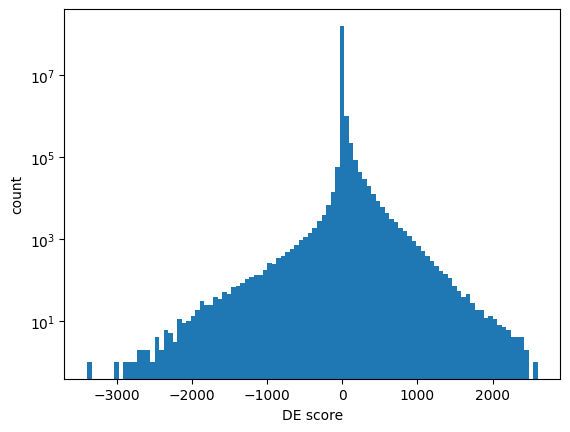

In [83]:
plt.hist(diffComp.layers['score'].reshape(-1), bins=100)
plt.xlabel('DE score')
plt.ylabel('count')
plt.yscale('log')
plt.show()

Plot distribution of FDR 

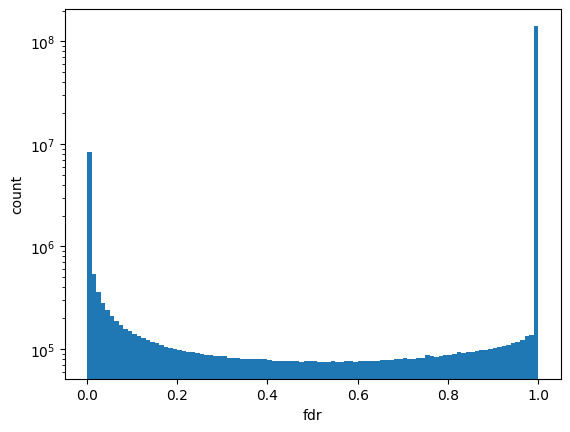

In [84]:
plt.hist(diffComp.layers['fdr'].reshape(-1), bins=100)
plt.xlabel('fdr')
plt.ylabel('count')
plt.yscale('log')
plt.show()

In [85]:
diffComp.layers['score-sig'] = diffComp.layers['score'].copy()
f = diffComp.layers['fdr'] > 0.05
diffComp.layers['score-sig'][f]= 0

Plot distribution of scores, conditional on being significant

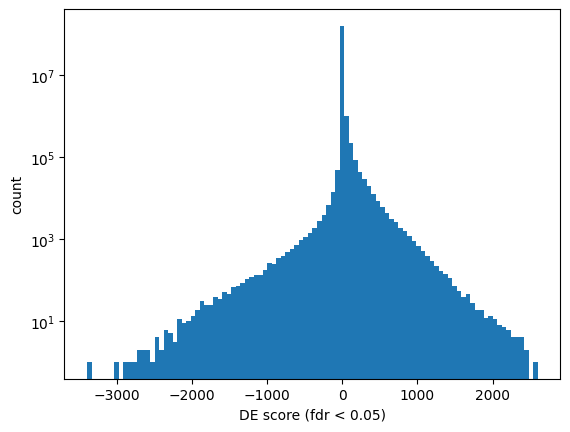

In [86]:
plt.hist(diffComp.layers['score-sig'].reshape(-1), bins=100)
plt.xlabel('DE score (fdr < 0.05)')
plt.ylabel('count')
plt.yscale('log')
plt.show()

### Compute diffusion maps

We use diffusion maps to sort genes along the circos plot, based on DE scores computed above

In [87]:
diffComp

AnnData object with n_obs × n_vars = 8798 × 18211
    obs: 'cell type', 'target', 'fracExp'
    layers: 'pval', 'fdr', 'lfc', 'score', 'score-sig'

In [88]:
diffComp.X = diffComp.layers['score']

In [89]:
cellTypes=diffComp.obs['cell type'].value_counts().index
sc.settings.verbosity = 0
diffComp.obs['cell_type_dc1'] = 0
diffComp.obs['cell_type_dc2'] = 0
!mkdir -p {output_dir}/diffusionComponents
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < 5):
        print(f'Skipping {cellType}, only {tmp.shape[0]} rows')
        continue
    init_npcs = np.min([50, tmp.shape[0]-2])
    sc.pp.pca(tmp, n_comps=init_npcs)
    if np.min(tmp.uns['pca']['variance'])==0:
        init_npcs = np.argmin(tmp.uns['pca']['variance'])
        tmp.uns['pca']['variance'] = tmp.uns['pca']['variance'][:init_npcs]
        tmp.uns['pca']['variance_ratio'] = tmp.uns['pca']['variance_ratio'][:init_npcs]
    #sc.pl.pca_variance_ratio(tmp, n_pcs=init_npcs, log=True)
    x = [x for x in range(len(tmp.uns['pca']['variance_ratio']))]
    y = np.log(tmp.uns['pca']['variance_ratio'])
    knee = KneeLocator(x=x, y=y, curve='convex', direction='decreasing', online=True, interp_method='polynomial')
    #knee.plot_knee_normalized()

    opt_n_pcs = knee.knee+1
    print('Optimal Number of PCs: ', str(opt_n_pcs))
    sc.pp.pca(tmp, n_comps=opt_n_pcs)
    #dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    #ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=15)
    dm_res = palantirFuncs.run_diffusion_maps(pd.DataFrame(tmp.obsm['X_pca']), n_components=15)
    ms_data = palantirFuncs.determine_multiscale_space(dm_res, n_eigs=15)
    tmp.obsm['DC'] = ms_data.to_numpy()
    diffComp.obs.loc[f,'cell_type_dc1'] = tmp.obsm['DC'][:,0]
    diffComp.obs.loc[f,'cell_type_dc2'] = tmp.obsm['DC'][:,1]
    
    # get a version normalized by cell type for circos plots
    maxval = np.max(np.abs(tmp.obsm['DC'][:,0]))
    if maxval == 0:
        maxval = 1
    diffComp.obs.loc[f,'cell_type_dc1_norm'] = tmp.obsm['DC'][:,0]/maxval

Stromal_cells (439, 18211)
Optimal Number of PCs:  15
Determing nearest neighbor graph...


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


growing_Tumor_clones (426, 18211)
Optimal Number of PCs:  13
Determing nearest neighbor graph...
shrinking_Tumor_clones (414, 18211)
Optimal Number of PCs:  11
Determing nearest neighbor graph...
stable_Tumor_clones (382, 18211)
Optimal Number of PCs:  9
Determing nearest neighbor graph...
Macrophages_phagocytic (366, 18211)
Optimal Number of PCs:  9
Determing nearest neighbor graph...
Macrophages_antigen_pres (365, 18211)
Optimal Number of PCs:  8
Determing nearest neighbor graph...
CD8_T_dpt_3 (333, 18211)
Optimal Number of PCs:  7
Determing nearest neighbor graph...
Endothelial_cells (319, 18211)
Optimal Number of PCs:  8
Determing nearest neighbor graph...
B_Plasma_cells (319, 18211)
Optimal Number of PCs:  8
Determing nearest neighbor graph...
Macrophages_M1_like (313, 18211)
Optimal Number of PCs:  7
Determing nearest neighbor graph...
CD8_T_dpt_1 (313, 18211)
Optimal Number of PCs:  6
Determing nearest neighbor graph...
CD8_T_dpt_2 (308, 18211)
Optimal Number of PCs:  6
Determin

__DC plots__

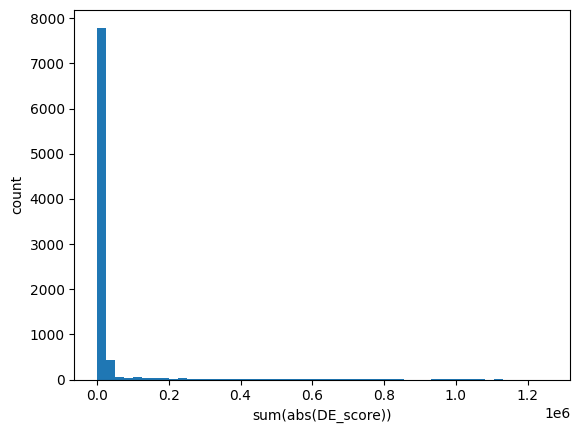

In [90]:
# size each receptor/ligand by sum of abs(DE scores) across all genes
diffComp.obs['absDE'] = np.sum(np.abs(diffComp.layers['score']), axis=1)
plt.hist(diffComp.obs['absDE'], bins=50)
plt.xlabel('sum(abs(DE_score))')
plt.ylabel('count')
diffComp.obs['absDE_scaled'] = diffComp.obs['absDE']/np.max(diffComp.obs['absDE'])

Plot diffusion components 2 vs 1 for each cell type. Shows distribution of transcriptional response.

In [ ]:
sc.settings.verbosity = 0
numLabel=10
sizeFactor=100  # adjust to scale poinst
for cellType in cellTypes:
    f = diffComp.obs['cell type'] == cellType
    tmp = diffComp[f].copy()
    print(cellType,tmp.shape)
    if(tmp.shape[0] < numLabel):
        continue
    plt.subplots(figsize=(4,4))
    
    xvals = np.array(tmp.obs['cell_type_dc1'])
    yvals = np.array(tmp.obs['cell_type_dc2'])
    sizevals = np.array(tmp.obs['absDE_scaled']*sizeFactor)
    labels = np.array(tmp.obs['target'])
    plt.scatter(xvals, yvals, s=sizevals)
    plt.title(cellType)
    
    texts = []
    tmpobs = tmp.obs.sort_values(by='absDE_scaled', ascending=False).iloc[:numLabel]
    for i in tmpobs.index:
        texts.append(plt.text(tmpobs.loc[i,'cell_type_dc1'], tmpobs.loc[i,'cell_type_dc2'], tmpobs.loc[i,'target'],
                             fontsize=10))
    f = list(range(0, len(x), 50))
    niter = adjust_text(texts, 
                        x=xvals, y=yvals, 
                        #avoid_self=True, force_text=(2,2),
                        #force_pull=(0.001,0.001),
                        expand_points=(0.1,0.1),
                        expand_text=(1.1,1.1),
                        arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))
                     
    
    plt.savefig(f'{output_dir}/diffusionComponents/diffusion_components_{cellType}.png', dpi=300, bbox_inches='tight')
    plt.show()

### GSEA analysis of DCs

GSEA analysis may yield some insight about biological processes underlying the diffusion components.

A GMT file is required, they may be specialized for each cell type, the ones we use are in the tutorial data directory.

__First, for each gene and each cell type, compute the correlation between DC1 and the DE Scores,
we will use this correlation as a score to feed GSEA__

In [92]:
for cellType in diffComp.obs['cell type'].unique():
    f = (diffComp.obs['cell type'] == cellType)
    print(cellType, sum(f), sum(diffComp.obs['cell type'] == cellType))
    dc = diffComp.obs.loc[f,'cell_type_dc1']
    corrCol = f'{cellType}_dc1_corr'
    for g in diffComp.var.index:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            diffComp.var.loc[g,corrCol] = np.corrcoef(dc.to_numpy(), diffComp[f,g].X.flatten())[0,1]

B_Plasma_cells 319 319
CD4_T_CM 298 298
CD4_T_dpt_1 303 303
CD4_T_dpt_2 298 298
CD4_T_dpt_3 303 303
CD8_T_CM 300 300
CD8_T_dpt_1 313 313
CD8_T_dpt_2 308 308
CD8_T_dpt_3 333 333
Cycling_cells 300 300
DC3 297 297
Endothelial_cells 319 319
Macrophages_M1_like 313 313
Macrophages_M2_like 302 302
Macrophages_antigen_pres 365 365
Macrophages_cycling 307 307
Macrophages_phagocytic 366 366
Monocytes 302 302
NK_cells 298 298
Stromal_cells 439 439
Treg 301 301
cDC1 297 297
cDC2 298 298
growing_Tumor_clones 426 426
pDCs 297 297
shrinking_Tumor_clones 414 414
stable_Tumor_clones 382 382


__If GMT file is same from same species as gene assembly, then no gene mapping is necessary.__

In this case, remove the argument gene_map=mToH_mapping in the call to ct.run_gsea in the following cell

In [93]:
gsea_map = {
    'B_Plasma_cells' : 'B_cells',
    'CD4_T_CM' : 'T_cells',
    'CD4_T_dpt_1' : 'T_cells',
    'CD4_T_dpt_2' : 'T_cells',
    'CD4_T_dpt_3' : 'T_cells',
    'CD8_T_CM' : 'T_cells',
    'CD8_T_dpt_1' : 'T_cells',
    'CD8_T_dpt_2' : 'T_cells',
    'CD8_T_dpt_3' : 'T_cells',
    'Cycling_cells' : 'T_cells',
    'DC3' : 'cDC',
    'Endothelial_cells' : 'Endothelial_cells',
    'Macrophages_M1_like' : 'Macrophages_mMDSC',
    'Macrophages_M2_like' : 'Macrophages_mMDSC',
    'Macrophages_antigen_pres' : 'Macrophages_mMDSC',
    'Macrophages_cycling' : 'Macrophages_mMDSC',
    'Macrophages_phagocytic' : 'Macrophages_mMDSC',
    'Mast_cells' : 'All_Immune_Signatures',
    'Monocytes' : 'Macrophages_mMDSC',
    'NK_cells' : 'NK_cells',
    'Stromal_cells' : 'Fibroblast_cells', 
    'Treg' : 'T_cells',
    'cDC1' : 'cDC',
    'cDC2' : 'cDC',
    'growing_Tumor_clones' : 'Tumor_cells',
    'pDCs' : 'pDC',
    'shrinking_Tumor_clones' : 'Tumor_cells',
    'stable_Tumor_clones' : 'Tumor_cells',
}

In [ ]:
# This runs GSEA in each cell type and loads the results
# Each cell type should take a minute or so
dc1_gsea_results = []
for cellType in diffComp.obs['cell type'].unique():
    gmtfile = f'{tutorial_dir}/data/GSEA/{gsea_map[cellType]}.gmt'
    if os.path.exists(gmtfile):
        print(f'Using {gmtfile} for {cellType}')
    else:
        gmtfile=f'{tutorial_dir}/data/GSEA/All_Immune_Signatures.gmt'
        print(f'No GMT file found for {cellType}... using default file {gmtfile}')
    if not os.path.exists(gmtfile):
        print(f'{gmtfile} not found')
        break
    gmtMeta = pd.read_csv(gmtfile, index_col=None, usecols=[0,1], header=None, delimiter='\t')
    gmtMeta.columns = ['name','desc']
    gmtMeta['name'] = gmtMeta['name'].str.strip().str.upper()
    gmtMeta.loc[gmtMeta['desc'].str.match('^>'),1]=''
    compName=f'{cellType}_dc1'
    output_root=f'{output_dir}/{cellType}'
    stat = f'{cellType}_dc1_corr'
    scores = diffComp.var[stat].copy()
    scores = scores.loc[scores != 0]
    scores = scores.loc[~np.isnan(scores)]
    if (scores.shape[0] < 2):
        continue
    scores.sort_values(ascending=False, inplace=True)
    rank = ct.gsea_linear_scale(scores)
    currResults = ct.run_gsea(rank, output_root, gmtfile=gmtfile, force=False, wait=True, label=compName, readonly=False,)
                             # gene_map=mToH_mapping)
    currResults['cell type'] = cellType
    currResults = currResults.merge(gmtMeta, on='name')
    currResults['name'] = currResults['name'] + ' ' + currResults['desc']
    dc1_gsea_results.append(currResults)
dc1_gsea_results = pd.concat(dc1_gsea_results).reset_index(drop=True)

Using ./data/GSEA/B_cells.gmt for B_Plasma_cells
calling bash -c '/opt/GSEA_Linux_4.3.2/gsea-cli.sh GSEAPreranked -rnk "./data/cell_type_ct_dpt/B_Plasma_cells/input.rnk" -gmx "./data/GSEA/B_cells.gmt" -collapse No_Collapse -mode Max_probe -norm meandiv -nperm 10000 -scoring_scheme weighted -rpt_label "B_Plasma_cells_dc1" -create_svgs true -include_only_symbols true -make_sets true -plot_top_x 20 -rnd_seed 888 -set_max 1500 -set_min 1 -zip_report false -out "./data/cell_type_ct_dpt/B_Plasma_cells"' > "./data/cell_type_ct_dpt/B_Plasma_cells/B_Plasma_cells_dc1_stdout.txt" 2>&1

Reading positive GSEA results rom ./data/cell_type_ct_dpt/B_Plasma_cells/B_Plasma_cells_dc1.GseaPreranked.1724520160390/gsea_report_for_na_pos_1724520160390.tsv
Reading negative GSEA results rom ./data/cell_type_ct_dpt/B_Plasma_cells/B_Plasma_cells_dc1.GseaPreranked.1724520160390/gsea_report_for_na_neg_1724520160390.tsv
Using ./data/GSEA/T_cells.gmt for CD4_T_CM
calling bash -c '/opt/GSEA_Linux_4.3.2/gsea-cli.sh GS

__Plot GSEA results in each cell type__

red (positive) results are positively correlated with DC1, whereas blue (negative) results are negatively correlated with DC1

In [97]:
outdir = output_dir

In [ ]:
fdr_cutoff = 0.05
for cellType in diffComp.obs['cell type'].unique():
    f = (dc1_gsea_results['cell type'] == cellType) & (dc1_gsea_results['fdr_q'] < fdr_cutoff)
    print(cellType, sum(f))
    tmp = dc1_gsea_results.loc[f]
    ct0=cellType.replace(' ','_').replace('/','_')
    ct.plot_gsea_results(tmp, fdr_cutoff=fdr_cutoff, title=cellType, plot_outfile=f'{outdir}/{cellType}/GSEA-score_fdr{fdr_cutoff}.png',
                         remove_strings=['MONOCYTES'])
    plt.show()

## Circos plot prep

First, make a data frame containing all relevant statistics about ligands and receptors
including numSigInt_fdr05 for receptors, ligand fdr and logFC, and diffusion component values (for sorting them along circle)

This should be filtered to only the ligands/receptors that should be plotted along circle

In [79]:
# combine data about ligands and receptors into one data frame

# Only keep receptors with a minimum number of interaction effects (numSigI1_fdr05 > 0)
# and ligands that interact with these receptors, and are differentially expressed (fdr < 0.05)

# a 'target' refers to a ligand or receptor, some can be both. The columns 'ligand' and 'receptor' are booleans
# set to True if the target is a ligand/receptor
degobs = deg.obs.loc[deg.obs['numSigI1_fdr05'] > 0]
target_stats = diffComp.obs.merge(degobs.rename(columns={'receptor':'target'}), on=['target', 'cell type'],how='outer')
target_stats['receptor'] = ~pd.isna(target_stats['numSigI1_fdr05'])
allReceptors = list(set(target_stats.loc[target_stats['receptor'], 'target']))
allLigands = list(set(interactions.loc[interactions['receptor'].isin(allReceptors),'ligand']))
target_stats['ligand'] = target_stats['target'].isin(allLigands)

target_stats = target_stats.merge(ligandsDE[['gene', 'cell type', 'log2FC', 'fdr']].rename(columns={'gene':'target'}), 
                                  on=['target', 'cell type'], how='left')

# remove ligands that are not DE
f = (target_stats['ligand']) & (target_stats['fdr'] >= 0.05)
f1 = (f) & (target_stats['receptor'])
target_stats.loc[f1,'ligand'] = False
f2 = (f) & (~target_stats['receptor'])
target_stats = target_stats.loc[~f2].reset_index(drop=True)

f = pd.isna(target_stats['numSigI1_fdr05'])
target_stats.loc[f,'numSigI1_fdr05'] = 0


In [80]:
target_stats

,cell type,target,fracExp,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,B_Plasma_cells,ADGRE5,0.109948,0.0,False,False,NaN,NaN
1,B_Plasma_cells,ADM,0.006283,0.0,False,False,0.011586,1.000000
2,B_Plasma_cells,AGRN,0.005236,0.0,False,False,-0.012665,1.000000
3,B_Plasma_cells,AGT,0.000000,0.0,False,False,NaN,1.000000
4,B_Plasma_cells,ALCAM,0.349738,0.0,False,False,0.181181,0.259558
...,...,...,...,...,...,...,...,...
6457,stable_Tumor_clones,WNT5B,0.024407,0.0,False,False,-0.003618,0.835107
6458,stable_Tumor_clones,WNT6,0.000000,0.0,False,False,NaN,1.000000
6459,stable_Tumor_clones,WNT7B,0.000000,0.0,False,False,NaN,1.000000
6460,stable_Tumor_clones,WNT8B,0.000453,0.0,False,False,0.000349,0.872114


In [81]:
# Show counts of ligands, receptors, some genes are both
target_stats[['ligand', 'receptor']].value_counts()

ligand  receptor
False   False       5986
True    False        387
False   True          89
dtype: int64

In [82]:
target_stats[['cell type', 'ligand', 'receptor']].value_counts()

cell type                 ligand  receptor
Stromal_cells             False   False       338
growing_Tumor_clones      False   False       325
shrinking_Tumor_clones    False   False       313
stable_Tumor_clones       False   False       281
Macrophages_phagocytic    False   False       265
Macrophages_antigen_pres  False   False       264
B_Plasma_cells            False   False       218
Endothelial_cells         False   False       218
Macrophages_M1_like       False   False       212
Macrophages_cycling       False   False       206
Monocytes                 False   False       201
Macrophages_M2_like       False   False       201
Treg                      False   False       200
Cycling_cells             False   False       199
cDC2                      False   False       197
NK_cells                  False   False       197
CD4_T_dpt_3               False   False       196
CD4_T_CM                  False   False       196
pDCs                      False   False       196
CD4_T_d

In [83]:
target_stats['cell type'].unique()

array(['B_Plasma_cells', 'CD4_T_CM', 'CD4_T_dpt_1', 'CD4_T_dpt_2',
       'CD4_T_dpt_3', 'CD8_T_CM', 'CD8_T_dpt_1', 'CD8_T_dpt_2',
       'CD8_T_dpt_3', 'Cycling_cells', 'DC3', 'Endothelial_cells',
       'Macrophages_M1_like', 'Macrophages_M2_like',
       'Macrophages_antigen_pres', 'Macrophages_cycling',
       'Macrophages_phagocytic', 'Monocytes', 'NK_cells', 'Stromal_cells',
       'Treg', 'cDC1', 'cDC2', 'growing_Tumor_clones', 'pDCs',
       'shrinking_Tumor_clones', 'stable_Tumor_clones'], dtype=object)

In [105]:
target_stats.loc[~target_stats['cell type'].isin(['Stromal_cells','Endothelial_cells']),:]

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
0,B_Plasma_cells,ADGRE5,0.109948,0.166172,0.532434,0.059288,3899.473389,0.003104,1.0,True,False,NaN,NaN
1,B_Plasma_cells,APLP2,0.223037,-0.296000,1.493316,-0.105608,6744.421875,0.005369,0.0,False,True,-0.276459,0.001138
2,B_Plasma_cells,APP,0.150785,-0.137428,0.869163,-0.049032,5459.486328,0.004346,0.0,False,True,-0.354128,0.000027
3,B_Plasma_cells,BSG,0.109948,-0.579907,0.136704,-0.206901,6793.208984,0.005408,13.0,True,False,NaN,NaN
4,B_Plasma_cells,BTLA,0.310995,-0.385250,1.711502,-0.137451,8710.187500,0.006934,0.0,False,True,-0.287936,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,stable_Tumor_clones,VEGFA,0.028261,-0.662877,0.492956,-0.167988,5832.452148,0.004643,0.0,False,True,0.010104,0.035093
1947,stable_Tumor_clones,VLDLR,0.246789,-1.526886,0.107521,-0.386947,13723.335938,0.010925,44.0,True,False,NaN,NaN
1948,stable_Tumor_clones,VSIR,0.003325,-1.536376,-1.219757,-0.389352,20094.273438,0.015997,0.0,False,True,-0.001476,0.035924
1949,stable_Tumor_clones,WNT10A,0.000302,3.386529,-0.127937,0.858223,16759.818359,0.013343,0.0,False,True,-0.836715,0.036224


In [106]:
target_stats.loc[target_stats["target"]=="CD58",:]

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr
72,CD8_T_CM,CD58,0.040000,-4.976825,-1.026393,-0.718368,10509.174805,0.008366,0.0,False,True,0.177713,5.377727e-04
340,Macrophages_M2_like,CD58,0.282651,1.537486,-1.623002,0.450043,6830.829102,0.005438,0.0,False,True,0.280697,1.889080e-02
569,Macrophages_phagocytic,CD58,0.416076,-2.517483,-1.530278,-0.505564,10381.990234,0.008265,0.0,False,True,0.198002,8.595673e-06
778,Stromal_cells,CD58,0.185417,-0.655030,-0.001199,-0.513176,19789.531250,0.015755,0.0,False,True,0.056133,3.682024e-02
1023,Treg,CD58,0.386256,0.427433,-0.804718,0.080968,3855.039795,0.003069,0.0,False,True,0.350528,7.197510e-08
1118,growing_Tumor_clones,CD58,0.368695,1.159640,-0.783205,0.766544,597966.000000,0.476048,0.0,False,True,0.241641,5.078184e-217
1483,shrinking_Tumor_clones,CD58,0.404403,0.294751,0.231503,0.127103,95345.125000,0.075905,0.0,False,True,0.335955,3.972288e-321
1800,stable_Tumor_clones,CD58,0.226613,-1.223599,0.742447,-0.310088,11221.238281,0.008933,0.0,False,True,0.062378,1.374090e-06


In [84]:
target_stats.loc[target_stats["target"]=="PDCD1",:]

,cell type,target,fracExp,numSigI1_fdr05,receptor,ligand,log2FC,fdr
947,CD4_T_dpt_3,PDCD1,0.384359,1.0,True,False,NaN,NaN
1360,CD8_T_dpt_1,PDCD1,0.068691,2.0,True,False,NaN,NaN
1803,CD8_T_dpt_3,PDCD1,0.357485,1.0,True,False,NaN,NaN


In [107]:
np.quantile(target_stats.loc[~target_stats['cell type'].isin(['Stromal_cells','Endothelial_cells']),:]['numSigI1_fdr05'],.7)

14.0

In [108]:
np.nanquantile(target_stats.loc[~target_stats['cell type'].isin(['Stromal_cells','Endothelial_cells']),:]['fdr'],.1)

1.3162030553174777e-146

In [109]:
np.nanquantile(target_stats.loc[~target_stats['cell type'].isin(['Stromal_cells','Endothelial_cells']),:]['log2FC'],.8)

0.22190238147019864

<Axes: xlabel='log2FC', ylabel='Count'>

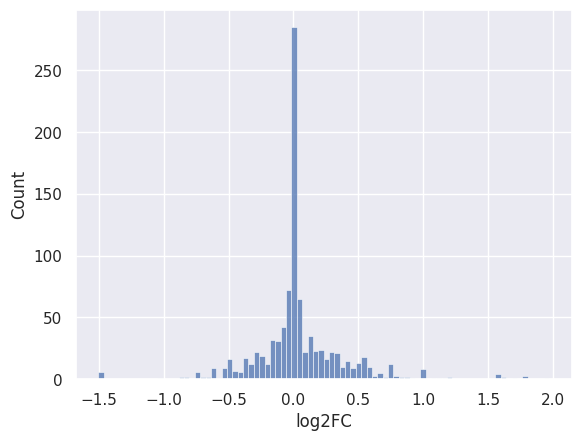

In [110]:
sns.histplot(target_stats.loc[~target_stats['cell type'].isin(['Stromal_cells','Endothelial_cells']),:],x='log2FC')

In [111]:
target_stats.to_csv(output_dir+"/target_stats.txt", sep='\t')

## Circos plot

In [7]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [8]:
output_dir='./cell_type_ct_dpt_032425'

In [10]:
# adata = sc.read_h5ad('../contact_tracing_merged_082224_processed.h5ad')
interactions = pd.read_csv(output_dir+'/ContactTracing_interactions.txt', sep="\t")
# deg = sc.read_h5ad(output_dir+'/deg.h5ad')
target_stats = pd.read_csv(output_dir+'/target_stats.txt', sep="\t", index_col=0)
# diffComp = sc.read_h5ad(output_dir+'/diffComp.h5ad')

In [11]:
target_stats['log10_numSigI1_fdr05'] = np.log10(target_stats['numSigI1_fdr05']+1)

In [12]:
import pickle

marker_genes_filepath = 'marker_genes_dict_030823.pickle'
with open(marker_genes_filepath, 'rb') as handle:
    marker_genes = pickle.load(handle)
tcell_marker_genes = []
for key in marker_genes.keys():
    tcell_marker_genes = tcell_marker_genes + marker_genes[key]
tcell_marker_genes = set(tcell_marker_genes) | set(['CD2','CD58','CD226','NECTIN2','NECTIN3','CD96','PVR']) # add CD58/CD2 and CD226/PVR/NECTIN2/TIGIT axes of interest
len(tcell_marker_genes)

698

In [13]:
term_exhaust = [
    "CD3G", "FASLG", "ID2", "LAG3", "RGS1", "CCL3", "CCL3L1", "KIAA1671", "SH2D2A", 
    "DUSP2", "PDCD1", "CD7", "NR4A2", "CD160", "PTPN22", "ABI3", "PTGER4", "GZMK", 
    "GZMA", "MBNL1", "VMP1", "PLAC8", "RGS3", "EFHD2", "GLRX", "CXCR6", "ARL6IP1", 
    "CCL4", "ISG15", "LAX1", "CD8A", "SERPINA3", "GZMB", "TOX"
]
precursor_exhaust = [
    "TCF7", "MS4A4A", "TNFSF8", "CXCL10", "EEF1B2", "ID3", "IL7R", "JUN", "LTB", 
    "XCL1", "SOCS3", "TRAF1", "EMB", "CRTAM", "EEF1G", "CD9", "ITGB1", "GPR183", 
    "ZFP36L1", "SLAMF6", "LY6E"
]
exhaust = ["TIGIT", "PDCD1", "CD274", "CTLA4", "LAG3", "HAVCR2", "CD244", "CD160"]

In [14]:
# use this to map receptor/ligand to its correlation with decipher_v1 from T cell trajectory analysis
tcell_gene_corr_dpt = pd.read_csv(output_dir+'/tcell_gene_corr_dpt.csv', index_col=0)
_max = np.max(np.abs(tcell_gene_corr_dpt)) # normalize correlations
tcell_gene_corr_dpt = tcell_gene_corr_dpt / _max

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
cellType_colormap = {
    'CD8_T_dpt_1' : '#482878',
    'CD8_T_dpt_2' : '#26828E',
    'CD8_T_dpt_3' : '#B5DE2B',
    'growing_Tumor_clones' : 'lightcoral',
    'shrinking_Tumor_clones' : 'lightskyblue',
}

In [19]:
ex = set(term_exhaust) | set(precursor_exhaust) | set(exhaust)
len(ex)

60

In [20]:
target_stats['exhaust'] = target_stats['target'].isin(ex) * 0.0

In [21]:
df = pd.read_csv(output_dir+'/ranked_interactions.txt', sep='\t')
df = df.loc[df['ligand'].isin(ex) | df['receptor'].isin(ex)]
ex_R = set(df['receptor'])
ex_L = set(df['ligand'])

In [22]:
df = pd.read_csv(output_dir+'/ranked_interactions.txt', sep='\t')
df = df.loc[df['ligand'].isin(tcell_marker_genes) | df['receptor'].isin(tcell_marker_genes)]
tcell_marker_genes_R = set(df['receptor'])
tcell_marker_genes_L = set(df['ligand'])

In [ ]:
# to guide visualization parameters (run each time):
sns.histplot(filtered_target_stats['degree'])
sns.histplot(filtered_target_stats['log2FC'])
print(np.nanquantile(filtered_target_stats['log2FC'],.95))
print(np.nanquantile(filtered_target_stats['log2FC'],.05))

## Figure S8C- Tumor + T cell + DC focused circos plot

In [ ]:
filter_cts = ['NK_cells', 'Cycling_cells', 'B_Plasma_cells', 'Mast_cells', 'Monocyte', 'M2-like_Macrophage', 'Phagocytic_Macrophage',
            'Antigen-presenting_Macrophage', 'M1-like_Macrophage', 'Cycling_Myeloid', 'stable_Tumor_clones', 'Stromal_cells',
            'Endothelial_cells', ] # only tumor + T cells + DCs
# filter_cts = None # otherwise set to None

sort_dpt = True

filtered_target_stats = target_stats.copy()

# focus on specific interactions
if filter_cts is not None:
    filtered_target_stats = filtered_target_stats.loc[~filtered_target_stats['cell type'].isin(filter_cts),:]
if sort_dpt:
    filtered_target_stats.loc[filtered_target_stats['cell type'].isin(['CD4+_T_cells', 'CD8+_T_cells', 'Naive_CD8+_T_cells']),'cell_type_dc1_norm'] = \
        filtered_target_stats.loc[filtered_target_stats['cell type'].isin(['CD4+_T_cells', 'CD8+_T_cells', 'Naive_CD8+_T_cells']),['target']].replace(tcell_gene_corr_dpt['0']).values

cellType_order = ['CD4_T_CM', 'CD4_T_dpt_1', 'CD4_T_dpt_2', 'CD4_T_dpt_3', 
                  'CD8_T_CM', 'CD8_T_dpt_1', 'CD8_T_dpt_2', 'CD8_T_dpt_3',
                  'NK_cells', 'Cycling_cells', 'Treg', 'B_Plasma_cells', 'Mast_cells',
                  'Monocyte', 'M2-like_Macrophage', 'Phagocytic_Macrophage', 'Antigen-presenting_Macrophage', 'M1-like_Macrophage', 'Cycling_Myeloid',
                  'cDC1', 'cDC2', 'DC3', 'pDCs',
                  'growing_Tumor_clones', 'shrinking_Tumor_clones','stable_Tumor_clones', 
                  'Stromal_cells', 'Endothelial_cells', ]

all_cells = cellType_order
immune = cellType_order[:12]
myeloid = cellType_order[12:19]
DC = cellType_order[19:23]
tumor = cellType_order[23:25]
stromal = cellType_order[26:28]

filtered_target_stats = filtered_target_stats.loc[filtered_target_stats['target'].isin(tcell_marker_genes_L|tcell_marker_genes_R),:]

# custom metrics for visualizations: 
# DE score is -logFC * log10(pval) for each R/L conditional on each L/R; `absDE` is sum of abs(DE)
filtered_target_stats['blanks'] = 0
filtered_target_stats['absDE_scaled'] = filtered_target_stats['absDE'] / np.max(filtered_target_stats['absDE'])

outdir=f'{output_dir}/circos_dc_t_tumor_CUIMC_only'
tmp = ct.make_circos_plot(interactions, filtered_target_stats,
                          numSigI1_stat='fracExp', links_min_numSigI1=0.01,
                          links_max_ligand_fdr= 0.01, 
                          links_min_ligand_absLog2FC= 0.01, 
                          log2FC_vmax=0.7,
                          max_thickness=10,
                          order_col='cell_type_dc1_norm',
                          histogram_plots= [], 
                          outdir=outdir, 
                          colorMap=cellType_colormap,
                          cellType_order = cellType_order,
                          cellType_labels=True, 
                          cellType_filter=immune[:9] + ['Treg']                 ,
                          labelSize=30, labelParallel='yes',
                         )

Removing 0 rows of target_stats that have cell_type_dc1_norm=NaN
 num_ligand = 202
 num_receptor = 138
Removing 1 cell Types that have no labels: CD4_T_dpt_2
target_stats.shape = (316, 18)
growing_Tumor_clones 96
shrinking_Tumor_clones 96
CD8_T_dpt_3 30
Treg 20
CD8_T_dpt_1 19
cDC2 17
CD8_T_dpt_2 13
CD4_T_dpt_1 8
CD4_T_dpt_3 7
cDC1 4
CD8_T_CM 2
DC3 2
pDCs 2
Wrote karyotype file with 13 chromosomes and 316 genes
Number of links: : 191
Wrote ./cell_type_ct_dpt_032425/circos_dc_t_tumor_CUIMC_only/circos.conf
Done making circos plot ./cell_type_ct_dpt_032425/circos_dc_t_tumor_CUIMC_only/circos.png
Placed 144 labels


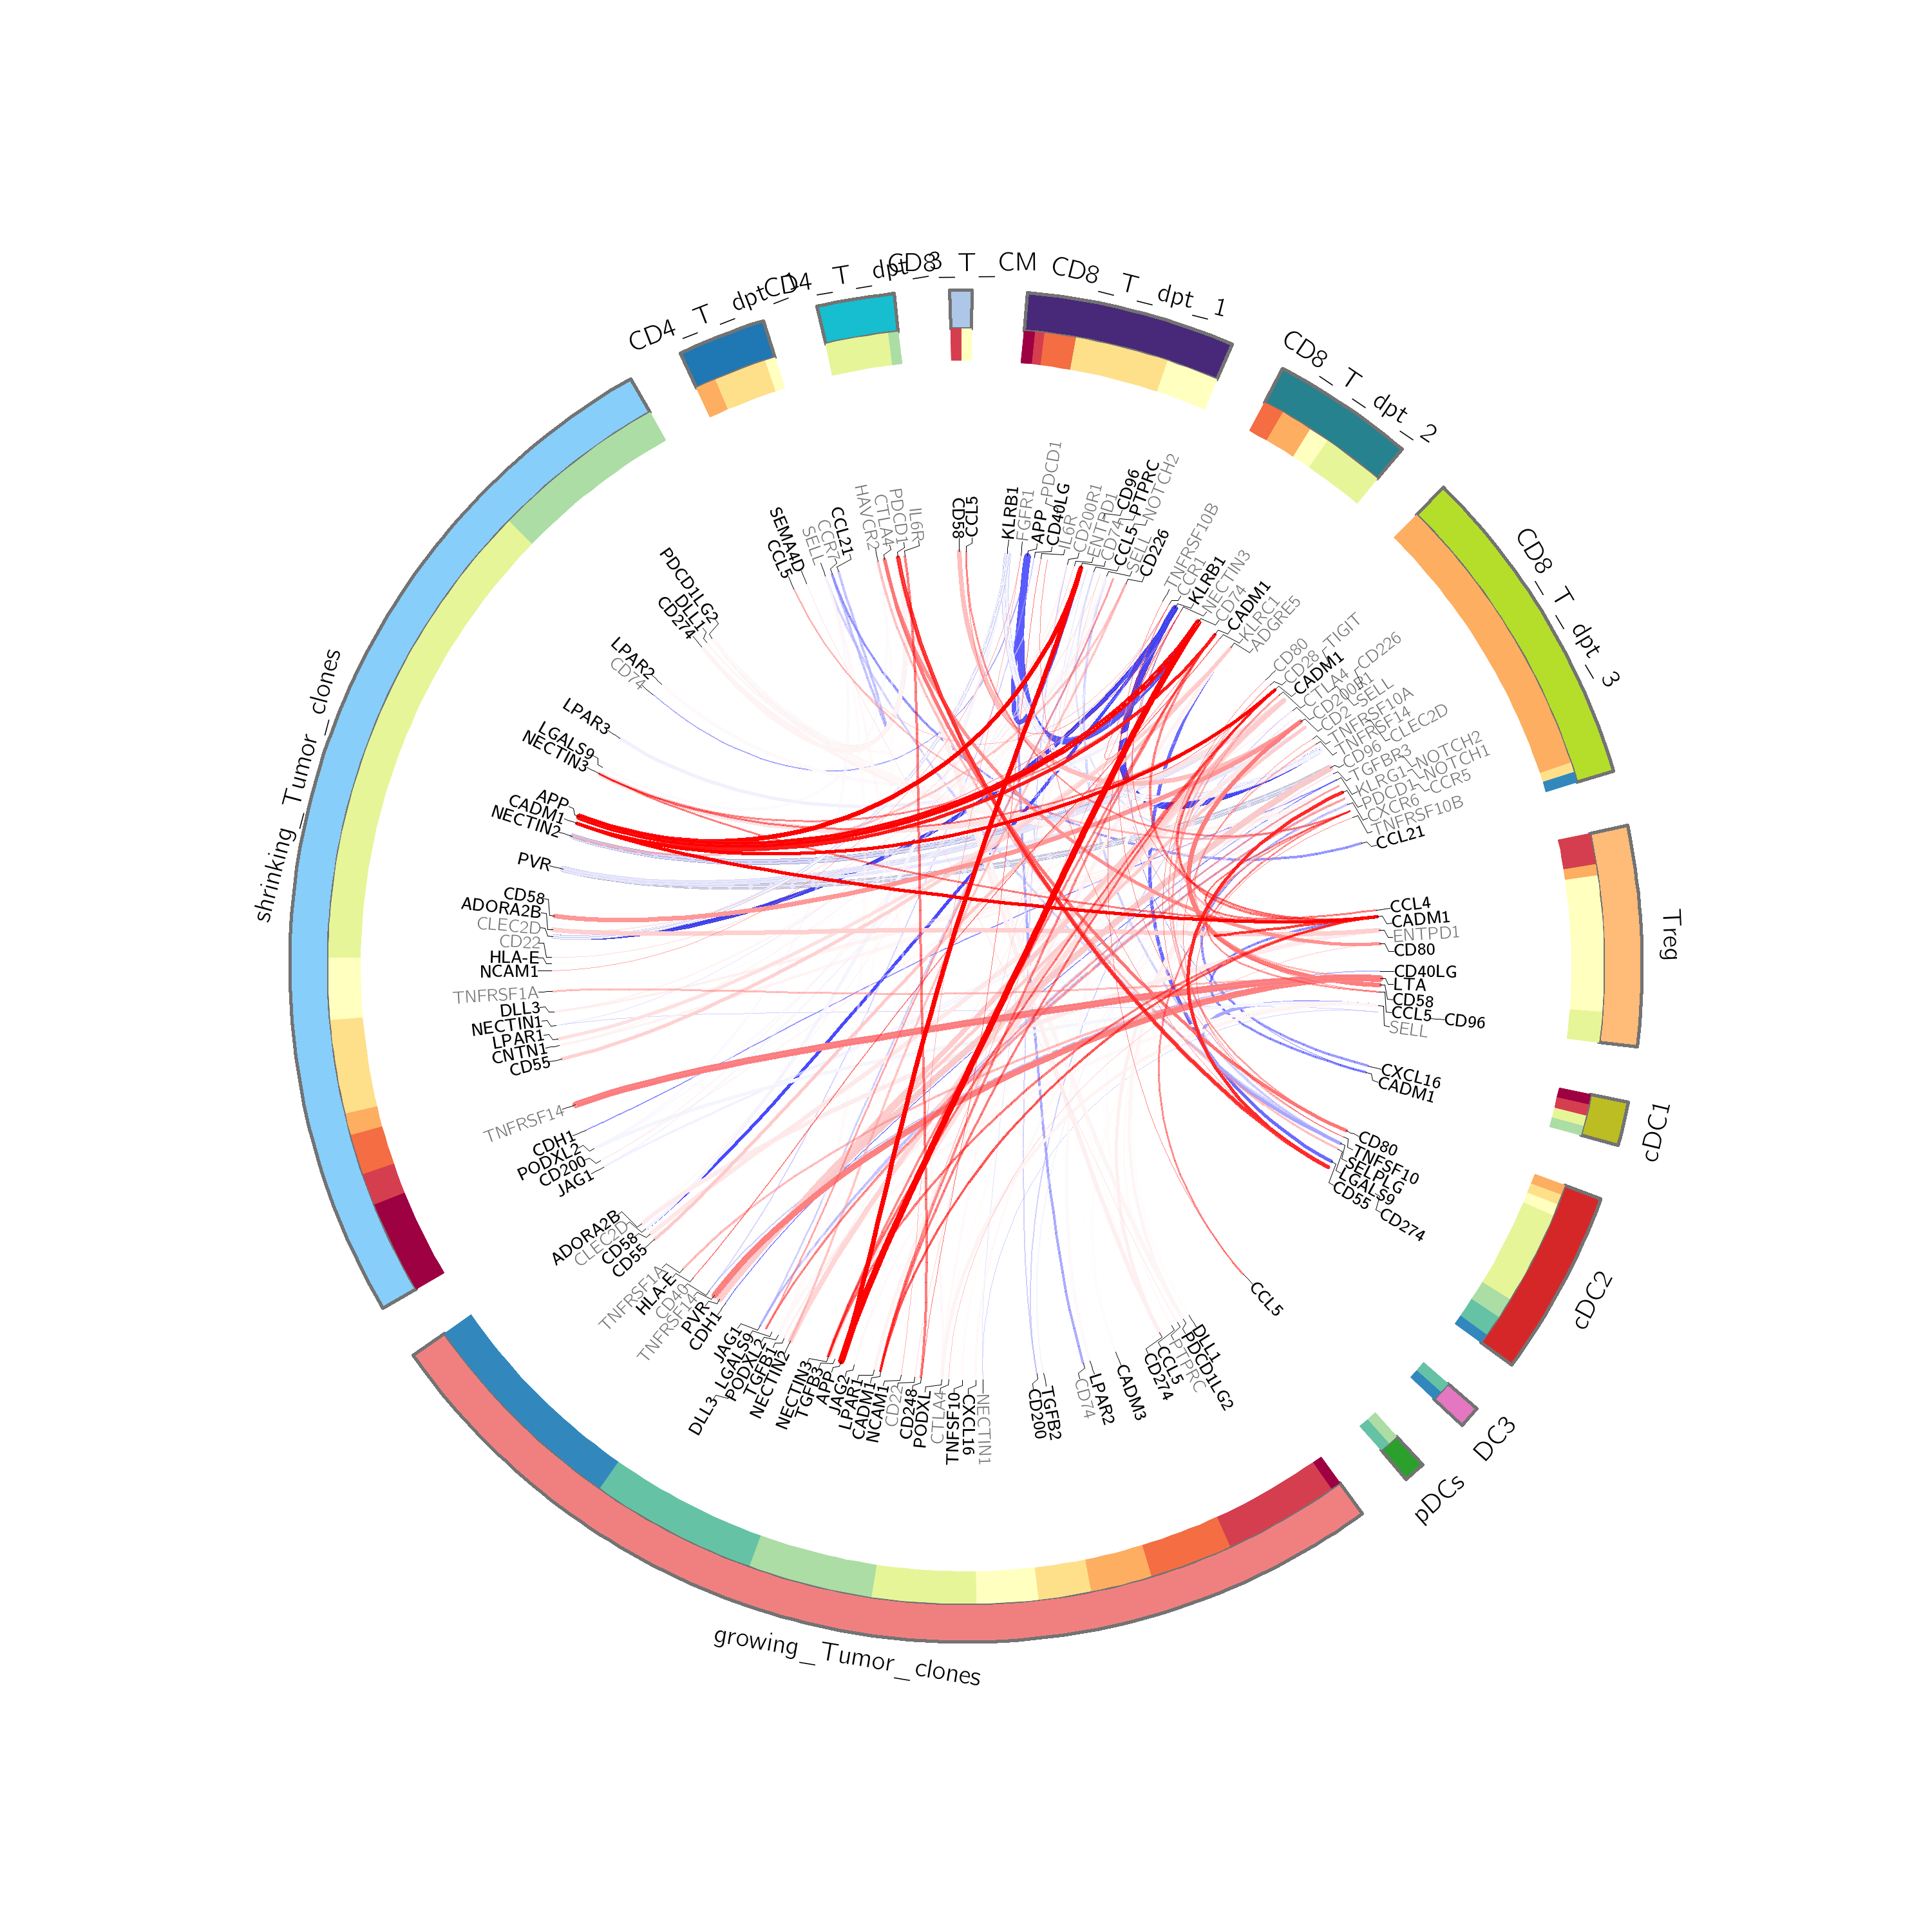

In [ ]:
Image(f'{outdir}/circos.png')

## Figure S8A- Hematopoietic compartment focused circos plot

In [ ]:
filter_cts = ['Stromal_cells','Endothelial_cells','growing_Tumor_clones', 'shrinking_Tumor_clones','stable_Tumor_clones',
                'Cycling_cells', 'Macrophages_cycling',] # hematopoietic focused cells
# filter_cts = None # otherwise set to None

sort_dpt = True

filtered_target_stats = target_stats.copy()

# focus on specific interactions
if filter_cts is not None:
    filtered_target_stats = filtered_target_stats.loc[~filtered_target_stats['cell type'].isin(filter_cts),:]
if sort_dpt:
    filtered_target_stats.loc[filtered_target_stats['cell type'].isin(['CD4+_T_cells', 'CD8+_T_cells', 'Naive_CD8+_T_cells']),'cell_type_dc1_norm'] = \
        filtered_target_stats.loc[filtered_target_stats['cell type'].isin(['CD4+_T_cells', 'CD8+_T_cells', 'Naive_CD8+_T_cells']),['target']].replace(tcell_gene_corr_dpt['0']).values

cellType_order = ['CD4_T_CM', 'CD4_T_dpt_1', 'CD4_T_dpt_2', 'CD4_T_dpt_3', 
                  'CD8_T_CM', 'CD8_T_dpt_1', 'CD8_T_dpt_2', 'CD8_T_dpt_3',
                  'NK_cells', 'Cycling_cells', 'Treg', 'B_Plasma_cells', 'Mast_cells',
                  'Monocyte', 'M2-like_Macrophage', 'Phagocytic_Macrophage', 'Antigen-presenting_Macrophage', 'M1-like_Macrophage', 'Cycling_Myeloid',
                  'cDC1', 'cDC2', 'DC3', 'pDCs',
                  'growing_Tumor_clones', 'shrinking_Tumor_clones','stable_Tumor_clones', 
                  'Stromal_cells', 'Endothelial_cells', ]
all_cells = cellType_order
immune = cellType_order[:12]
myeloid = cellType_order[12:19]
DC = cellType_order[19:23]
tumor = cellType_order[23:25]
stromal = cellType_order[26:28]

# only examine interactions related to known T cell processes
filtered_target_stats = filtered_target_stats.loc[filtered_target_stats['target'].isin(tcell_marker_genes_L|tcell_marker_genes_R),:]

# custom metrics for visualizations: 
# DE score is -logFC * log10(pval) for each R/L conditional on each L/R; `absDE` is sum of abs(DE)
filtered_target_stats['blanks'] = 0
filtered_target_stats['absDE_scaled'] = filtered_target_stats['absDE'] / np.max(filtered_target_stats['absDE'])

# if visualizing degree of connection as width, have to do dry run first (circos_myeloid_t_CUIMC_only)
links = pd.read_csv(f'{output_dir}/circos_myeloid_t_CUIMC_only/links.txt', sep='\t', header=None)
links['start'] = links[0] + "_" + links[1].astype('str') + "_" + links[2].astype('str')
links['end'] = links[3] + "_" + links[4].astype('str') + "_" + links[5].astype('str')
links = links[['start','end']]
labels = pd.read_csv(f'{output_dir}/circos_myeloid_t_CUIMC_only/labels.txt', sep='\t', header=None)
labels['link'] = labels[0] + "_" + labels[1].astype('str') + "_" + labels[2].astype('str')
labels['cell type'] = labels[0].copy()
labels['target'] = labels[3].copy()
labels = labels[['link','cell type','target']]
labels['degree'] = labels['link'].apply(
    lambda x: (links['start'].isin([x])).sum() + (links['end'].isin([x])).sum()
)
filtered_target_stats['cell type lower'] = filtered_target_stats['cell type'].str.lower()
labels['cell type lower'] = labels['cell type'].copy()
filtered_target_stats = pd.merge(filtered_target_stats, labels[['cell type lower', 'target', 'degree']], on=['cell type lower', 'target'], how='left')
filtered_target_stats['degree'] = filtered_target_stats['degree'].fillna(1)

outdir=f'{output_dir}/circos_myeloid_t_degree_CUIMC_only'
tmp = ct.make_circos_plot(interactions, filtered_target_stats,
                          numSigI1_stat='degree', links_min_numSigI1=6,
                          links_max_ligand_fdr= 0.01, 
                          links_min_ligand_absLog2FC= 0.01, 
                          log2FC_vmax=0.7,
                          max_thickness=10,
                          order_col='cell_type_dc1_norm',
                          histogram_plots= [], 
                          outdir=outdir, 
                          colorMap=cellType_colormap,
                          cellType_order = cellType_order,
                          cellType_labels=True, 
                          cellType_filter=None,
                          labelSize=30, labelParallel='yes',
                         )

In [ ]:
# for other external analyses
f = target_stats['cell type'].isin(['growing_Tumor_clones'])
f = f & target_stats['ligand']
target_stats[f].to_csv('growing_ct_ligands_df_032425.csv')

f = target_stats['cell type'].isin(['shrinking_Tumor_clones'])
f = f & target_stats['ligand']
target_stats[f].to_csv('shrinking_ct_ligands_df_032425.csv')

In [ ]:
df = pd.read_csv(output_dir+'/ranked_interactions.txt', sep='\t')
df = df.loc[df['ligand'].isin(tcell_marker_genes) | df['receptor'].isin(tcell_marker_genes)]
df = df[df['ligandDE']]

# increasing/decreasing
df = df[df['log2FC_ligand']>0]

# T dpt choice
df = df[df['cell_type_receptor'].isin(['CD8_T_dpt_2'])]

# growing/shrinking set comparison
set1 = set(df[df['cell_type_ligand'].isin(['growing_Tumor_clones'])]['ligand'])
set2 = set(df[df['cell_type_ligand'].isin(['shrinking_Tumor_clones'])]['ligand'])

print("both growing and shrinking:",sorted(set1&set2))
print("growing but not shrinking:",sorted(set1.difference(set2)))
print("shrinking but not growing:",sorted(set2.difference(set1)))cell_type_main_plot

both growing and shrinking: ['ADORA2B', 'APP', 'CADM1', 'CADM3', 'CCL5', 'CD274', 'CD55', 'CD58', 'CNTN1', 'CXCL10', 'CXCL12', 'CXCL16', 'CXCL9', 'DLL1', 'DLL3', 'HLA-E', 'JAG2', 'LPAR1', 'LPAR2', 'NECTIN3', 'PDCD1LG2', 'PODXL']
growing but not shrinking: ['ADORA1', 'ADORA2A', 'DLL4', 'LGALS9', 'LPAR3', 'NECTIN2', 'PODXL2', 'PVR', 'SEMA4D', 'SFTPD', 'TGFB1', 'TGFB3', 'TNFSF10', 'TNFSF9']
shrinking but not growing: ['CD160', 'CD200', 'CD34', 'CD86', 'FGL1', 'KLRB1', 'SELPLG', 'THY1']


# Additional downstream analysis figures

## Figure 7B- Tumor ligand interaction chart

In [ ]:
ligand_interpretation = pd.read_csv(output_dir+'/circos_dc_t_tumor_CUIMC_only/growing_shrinking_ligand_interpretation_030425.csv')

In [ ]:
ligand_interpretation = ligand_interpretation[ligand_interpretation['IFNg'] | ligand_interpretation['IL6_JAK_STAT'] | ligand_interpretation['prev_resistance'] | ligand_interpretation['inflammation'] | ligand_interpretation['immune_regulation'] | ligand_interpretation['adhesion regulation'] | ligand_interpretation['VEGF']]

In [ ]:
# search for growing
expanding = ligand_interpretation[ligand_interpretation['comparison'].isin([
    'more downregulated in growing',
    'downregulated in growing',
    # 'upregulated in growing',
    'less upregulated in growing', 
    # 'more upregulated in growing', 
    # 'more downregulated in shrinking'
]
)]

In [ ]:
print(list(expanding['target']))

In [ ]:
# search for shrinking
contracting = ligand_interpretation[ligand_interpretation['comparison'].isin(
['less downregulated in shrinking','upregulated in shrinking','upregulated in shrinking','downregulated in shrinking',
 'more upregulated in shrinking','less upregulated in shrinking','less downregulated in growing',]
)]

In [ ]:
print(list(contracting['target']))

In [ ]:
contracting = ['CD274','CD58','NECTIN2','PVR','LGALS9'] # ['CD58','NECTIN2','CD200','PVR']
expanding = ['CD274','CD58','NECTIN2','PVR','LGALS9'] # ['CD274','NECTIN2','CD200','PVR'] 

df_contracting = target_stats[target_stats['target'].isin(contracting) &\
                      target_stats['cell type'].isin(['shrinking_Tumor_clones'])]
df_expanding = target_stats[target_stats['target'].isin(expanding) &\
                      target_stats['cell type'].isin(['growing_Tumor_clones'])]

In [39]:
display(df_contracting)
display(df_expanding)

,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,log10_numSigI1_fdr05,exhaust
1474,shrinking_Tumor_clones,CD274,0.013986,0.595886,-0.344602,0.306942,23999.008,0.019734,0.0,False,True,0.028330,5.143899e-62,0.000000,0.0
1482,shrinking_Tumor_clones,CD58,0.396634,0.251091,-0.227729,0.129338,90094.550,0.074081,0.0,False,True,0.280440,9.746123e-270,0.000000,0.0
1595,shrinking_Tumor_clones,LGALS9,0.025970,0.329414,2.045702,0.169682,320706.220,0.263705,0.0,False,True,-0.017335,1.100848e-64,0.000000,0.0
1619,shrinking_Tumor_clones,NECTIN2,0.228778,0.295658,1.879021,0.152294,359708.660,0.295775,12468.0,True,True,-0.103339,8.880477e-99,4.095832,0.0
1681,shrinking_Tumor_clones,PVR,0.228066,0.286209,1.649257,0.147427,219105.690,0.180163,12819.0,True,True,-0.061742,1.940918e-38,4.107888,0.0


,cell type,target,fracExp,cell_type_dc1,cell_type_dc2,cell_type_dc1_norm,absDE,absDE_scaled,numSigI1_fdr05,receptor,ligand,log2FC,fdr,log10_numSigI1_fdr05,exhaust
1136,growing_Tumor_clones,CD274,0.030639,-1.096964,0.057469,-0.720281,38291.387,0.031486,0.0,False,True,0.039155,3.527587e-27,0.000000,0.0
1145,growing_Tumor_clones,CD58,0.368570,1.124342,0.774569,0.738258,597626.800,0.491407,0.0,False,True,0.065406,2.172280e-25,0.000000,0.0
1258,growing_Tumor_clones,LGALS9,0.032452,0.874067,-1.000631,0.573924,298265.300,0.245253,0.0,False,True,0.015566,1.515069e-11,0.000000,0.0
1283,growing_Tumor_clones,NECTIN2,0.258656,0.794589,-0.642133,0.521738,537470.440,0.441942,3003.0,True,True,0.113494,3.369242e-45,3.477700,0.0
1341,growing_Tumor_clones,PVR,0.247472,1.012375,0.137676,0.664739,541987.060,0.445656,675.0,True,True,0.141927,3.886700e-68,2.829947,0.0


In [57]:
# read in CIs from GLMs fit earlier
CI_shrinking = pd.read_csv('cell_type_ct_dpt_032425/MAST_between_conditions/shrinking_Tumor_clones/Treated_vs_Untreated.csv', index_col=0)
df_contracting.loc[:,'ci.hi'] = 0
df_contracting.loc[:,'ci.lo'] = 0
for target in df_contracting['target']:
    df_contracting.loc[df_contracting['target']==target, 'ci.hi'] = CI_shrinking.loc[CI_shrinking['primerid']==target, 'ci.hi'].values
    df_contracting.loc[df_contracting['target']==target, 'ci.lo'] = CI_shrinking.loc[CI_shrinking['primerid']==target, 'ci.lo'].values
    df_contracting['error_low'] = df_contracting['log2FC']-df_contracting['ci.lo']
    df_contracting['error_high'] = df_contracting['ci.hi']-df_contracting['log2FC']

CI_growing = pd.read_csv('cell_type_ct_dpt_032425/MAST_between_conditions/growing_Tumor_clones/Treated_vs_Untreated.csv', index_col=0)
df_expanding.loc[:,'ci.hi'] = 0
df_expanding.loc[:,'ci.lo'] = 0
for target in df_expanding['target']:
    df_expanding.loc[df_expanding['target']==target, 'ci.hi'] = CI_growing.loc[CI_growing['primerid']==target, 'ci.hi'].values
    df_expanding.loc[df_expanding['target']==target, 'ci.lo'] = CI_growing.loc[CI_growing['primerid']==target, 'ci.lo'].values
    df_expanding['error_low'] = df_expanding['log2FC']-df_expanding['ci.lo']
    df_expanding['error_high'] = df_expanding['ci.hi']-df_expanding['log2FC']

/tmp/ipykernel_3870/2215309830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contracting.loc[:,'ci.hi'] = 0
/tmp/ipykernel_3870/2215309830.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_contracting.loc[:,'ci.hi'] = 0
/tmp/ipykernel_3870/2215309830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

/tmp/ipykernel_3870/2933025862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_expanding['clone']='expanding'; df_contracting['clone']='shrinking'


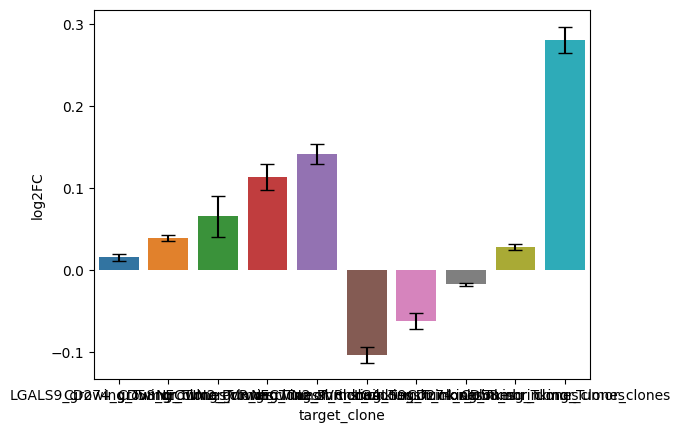

In [ ]:
matplotlib.rcParams.update({'errorbar.capsize': 5})
df_expanding['clone']='expanding'; df_contracting['clone']='shrinking'
df_both = pd.concat([df_expanding.sort_values('log2FC'), df_contracting.sort_values('log2FC')])
df_both['target_clone'] = df_both['target'] + "_" + df_both['cell type']

fig = plt.figure()
sns.barplot(df_both, x='target_clone', y='log2FC', errorbar=None, yerr=[df_both['error_low'],df_both['error_high']],
            ecolor='black', error_kw={'markeredgewidth':1}
           )

fig.savefig('expanding_contracting_lfc.pdf')

## Figure S8E- Tumor clone ligand expression heatmap

In [ ]:
# includes all ligands with FDR < 0.05 (visualization excludes fdr<0.01 and lfc<0.01)
clone_ligands_df = pd.read_csv(output_dir+'/circos_dc_t_tumor_CUIMC_only/growing_shrinking_ligand_interpretation_030325.csv')
clone_ligands_df = clone_ligands_df[clone_ligands_df['IFNg'] | clone_ligands_df['IL6_JAK_STAT'] | clone_ligands_df['prev_resistance'] | clone_ligands_df['inflammation'] | clone_ligands_df['immune_regulation'] | clone_ligands_df['adhesion regulation'] | clone_ligands_df['VEGF']]

In [174]:
clone_ligands_clustermap = clone_ligands_df.pivot(columns='target', index='clone', values='log2FC')
clone_ligands_clustermap.fillna(0, inplace=True)
clone_ligands_clustermap.columns = list(clone_ligands_df['target'].unique())

In [175]:
# make row colors for pathways
row_colors=clone_ligands_df.loc[:,['target','IFNg','IL6_JAK_STAT','prev_resistance','inflammation','immune_regulation','adhesion regulation','VEGF']]
row_colors = row_colors.groupby('target').any().reset_index() # OR operator on duplicates
row_colors['IFNg'] = row_colors['IFNg'].replace({True:'red', False:'gray'})
row_colors['IL6_JAK_STAT'] = row_colors['IL6_JAK_STAT'].replace({True:'orange', False:'gray'})
row_colors['prev_resistance'] = row_colors['prev_resistance'].replace({True:'blue', False:'gray'})
row_colors['inflammation'] = row_colors['inflammation'].replace({True:'green', False:'gray'})
row_colors['immune_regulation'] = row_colors['immune_regulation'].replace({True:'magenta', False:'gray'})
row_colors['adhesion regulation'] = row_colors['adhesion regulation'].replace({True:'y', False:'gray'})
row_colors['VEGF'] = row_colors['VEGF'].replace({True:'cyan', False:'gray'})
row_colors = row_colors.set_index('target')

-0.03586664509999999
0.1426181137


<Axes: ylabel='Count'>

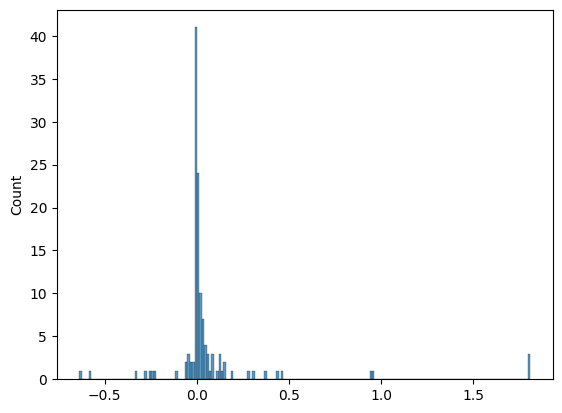

In [ ]:
# to guide visualization parameters
print(np.quantile(clone_ligands_clustermap.values.flatten(), .1))
print(np.quantile(clone_ligands_clustermap.values.flatten(), .9))
sns.histplot(clone_ligands_clustermap.values.flatten())

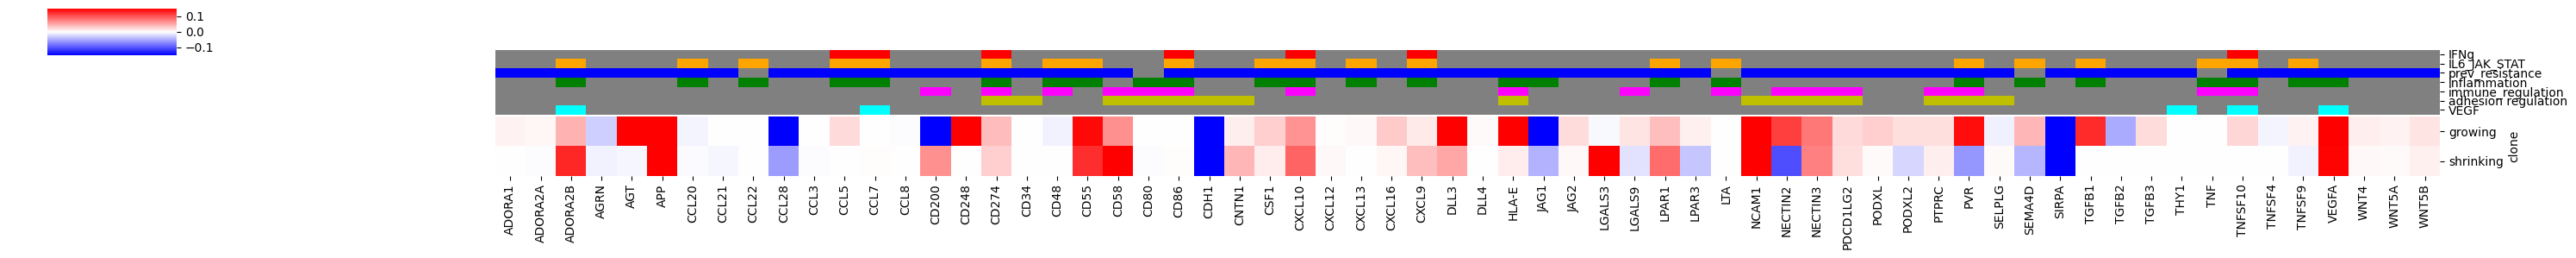

In [180]:
cm = sns.clustermap(clone_ligands_clustermap, cmap='bwr', vmin=-.15, vmax=.15,
                    row_cluster=False, col_cluster=False, col_colors=row_colors, xticklabels=True,
                    figsize=(30,3), colors_ratio=.06,
              )
cm.savefig('tumor_ligand_interpretation_cluster_lfc.pdf', dpi=300)

In [ ]:
# ! zip -r data/cell_type_ct_dpt.zip data/cell_type_ct_dpt